In [8]:
import pygame as pg
import sys
import random
import numpy as np

In [9]:
def obstacle_render(obs_list,obst_list):
    if obs_list:
        for i in range (len(obs_list)):
            screen.blit(pipe,pipe.get_rect(topright=obs_list[i]))
            screen.blit(pipet,pipet.get_rect(topright=obst_list[i]))
            obst_list[i][0]=obst_list[i][0]-4
            obs_list[i][0]=obst_list[i][0]-4
        if obs_list[0][0]<100:
            del obs_list[0]
            del obst_list[0]
        return obs_list,obst_list
    else:
        return[],[]

In [10]:
def create_tile_encoding(state, num_tiles_x=50, num_tiles_y=100, num_tiles_velocity=10):
    # Define the ranges for x, y, and velocity
    x=state[0]
    y=state[1]
    velocity=state[2]
    min_x, max_x = 0, 620
    min_y, max_y = 0, 1000
    min_velocity, max_velocity = 0, 69
    
    # Calculate tile widths for each dimension
    tile_width_x = (max_x - min_x) / num_tiles_x
    tile_width_y = (max_y - min_y) / num_tiles_y
    tile_width_velocity = (max_velocity - min_velocity) / num_tiles_velocity
    
    # Calculate the tile indices for each dimension
    tile_index_x = int((x - min_x) // tile_width_x)
    tile_index_y = int((y - min_y) // tile_width_y)
    tile_index_velocity = int((velocity - min_velocity) // tile_width_velocity)
    
    return [tile_index_x,tile_index_y,tile_index_velocity]

In [11]:
# x = horizontal distance between birdcenter and the pipe right range={0,4,....,604}, 50 tiles
# y = vertical distance of birdcenter and bottom pipe top range=[-300,475], 50 tiles
# z = velocity of the bird range=[-47,21], 10 tiles 
# last one denotes action
Q_value=np.zeros((50,100,10,2))

In [12]:
eps=0.0001
td_error=0.8
Y=0.8

In [13]:
def get_next_state(cur,obs_list):
    nexts=[0,0,0]
    if obs_list[0][0]==100:
        nexts[0]=(obs_list[1][0]-100)/4
        if cur[3]==0:
            nexts[1]=int(obs_list[1][1]-s+(t+0.5)*(t+0.5)-(t+0.5)*a+301)
            nexts[2]=a-(t+0.5)*2+47
        if cur[3]==1:
            nexts[1]=int(obs_list[1][1]-(s+t*t-t*a + 0.5*0.5 -0.5*21)+301)
            nexts[2]=21+47
    else:
        nexts[0]=cur[0]-1
        if cur[3]==0:
            nexts[1]=int(obs_list[0][1]-s+(t+0.5)*(t+0.5)-(t+0.5)*a+301)
            nexts[2]=a-(t+0.5)*2+47
        if cur[3]==1:
            nexts[1]=int(obs_list[0][1]-(s+t*t-t*a + 0.5*0.5 -0.5*21)+301)
            nexts[2]=21+47
    for i in range(3):
        nexts[i]=int(nexts[i])
    return nexts

In [14]:

pg.init()
screen=pg.display.set_mode((1200,576))
pg.display.set_caption("Hello_fine")
clock=pg.time.Clock()
font = pg.font.Font('freesansbold.ttf', 22)
sky=pg.image.load('game_dev/finalbg.jpg').convert()
pipe=pg.image.load('game_dev/pipe.png').convert_alpha()
pipe=pg.transform.scale(pipe,(100,500))
pipet=pg.transform.rotate(pipe,180)
pipet=pg.transform.flip(pipet,True,False)
pipet_rect=pipet.get_rect(topleft=(1200,-50))
pipe_rect=pipe.get_rect(topleft=(1200,300))
pipe_rect_copy=pipe.get_rect(topleft=(550,300))
pipet_rect_copy=pipet.get_rect(topleft=(550,-50))
bird=pg.image.load('game_dev/bird.png').convert_alpha()
bird=pg.transform.scale(bird,(70,50))
bird_rect=bird.get_rect(center=(100,100))
sbt=font.render("START",True,"red")
sbt_rect=sbt.get_rect(center=(600,288))
screen.blit(sbt,sbt_rect)

#defining timer for the obstacles to occur
for i in range(1000):
    bird_rect=bird.get_rect(center=(100,400))
    timer=pg.USEREVENT+1
    pg.time.set_timer(timer,2000)

    #bird=pg.transform.rotate(bird,-30)
    obs_list=[[500,400],[900,300],[1200,400]]
    obst_list=[[500,400-680],[900,300-680],[1200,400-680]]
    t=0
    a=0
    score="0"
    s=bird_rect.centery
    text = font.render(score, True, (77,208,225))
    text_rect = text.get_rect(center=(600,80))
    el=pg.draw.circle(screen,"blue",bird_rect.center,20)
    done=False
    cur_st=[0,0,0]
    cur_st[0]=(obs_list[0][0]-100)/4
    cur_st[1]=obs_list[0][1]-bird_rect.centery+301
    cur_st[2]=0
    while not done:
        #draw everything and update
        for event in pg.event.get():
            if event.type==pg.QUIT:
                print(l)
                pg.quit()
                sys.exit()
            #if event.type==pg.KEYDOWN:
                #s=s+t*t-t*a
                #a=21
                #t=0.5
            if event.type==timer:
                x=4*random.randint(300,330)
                y=400+random.randint(-150,100)
                obs_list.append([x,y])
                obst_list.append([x,y-680])
        # defining thr rectangle postions
        el=pg.draw.circle(screen,"blue",bird_rect.center,20)
        
        #S
        
        screen.blit(sky,(-100,0))
        bird_rect.centery=s+t*t-t*a
        v=a-t*2
        screen.blit(bird,bird_rect)
        screen.blit(text,text_rect)

        obs_list,obst_list=obstacle_render(obs_list,obst_list)
        cur_st_en=create_tile_encoding(cur_st)
        #A
        if random.uniform(0,1)<eps:
            action=random.randint(0,1)
        else:
            action=np.argmax(Q_value[tuple(cur_st_en)])
        cur_st.append(action)
        cur_st_en.append(action)
        
        #S'
        next_state=get_next_state(cur_st,obs_list)
        next_state_en=create_tile_encoding(next_state)
        print(next_state[2],next_state_en[2])
        # in one time stamp x reduces by one and y by an amout specified by an equation of motion
        # so in order to find the subsequent states i would need to do a lookahead in the s using a hypothetical 
        # jump or no jump and then check the max of q values of both states and decide greedly....

        
        
        if cur_st[3]==0:
            ys=s+(t+0.5)*(t+0.5)-(t+0.5)*a
        else:
            ys=s+t*t-t*a + 0.5*0.5 -0.5*21
        el1=pg.draw.circle(screen,"blue",(104,ys),20)
        if  el1.colliderect(pipe.get_rect(topright=obs_list[0])) or el1.colliderect(pipet.get_rect(topright=obst_list[0])) or el1.bottom>=571 or el1.top<=5:
            reward=-300
            done=True
            Q_value[tuple(cur_st_en)]+=td_error*(reward-Y*Q_value[tuple(cur_st_en)])
        else:
            if random.uniform(0,1)<eps:
                action_next=random.randint(0,1)
            else:
                action_next=np.argmax(Q_value[tuple(next_state_en)])
            next_state.append(action_next)
            next_state_en.append(action_next)
            reward=0.5
            if next_state[0]==0:
                reward=10
            Q_value[tuple(cur_st_en)]+=td_error*(reward + Y*(Q_value[tuple(next_state_en)]-Q_value[tuple(cur_st_en)]))

        if action==1:
            s=s+t*t-t*a
            t=0
            a=21

        if obs_list and el.right==obs_list[0][0]+16:
            score=str(eval(score)+1)
            smax=max(0,eval(score))
            print(smax)

            text = font.render(score, True,(77,208,225))
        #if (obs_list and obst_list and (el.colliderect(pipe.get_rect(topleft=obs_list[0])) or el.colliderect(pipet.get_rect(topleft=obst_list[0])))) or bird_rect.bottom>=576 or bird_rect.top<=0:
            #pg.quit()
            #sys.exit()
        print(next_state[1])
        t=t+0.5
        pg.display.update()
        #clock.tick(60)
        cur_st=[next_state[0],next_state[1],next_state[2]]
    

46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
23 3
445
22 3
457
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
23 3
445
68 9
167
66 9
137
65 9
127
64 9
119
63 9
110
62 8
103
61 8
95
60 8
89
59 8
82
58 8
77
57 8
71
56 8
67
55 7
62
54 7
59
53 7
55
52 7
53
51 7
50
50 7
49
49 7
47
48 6
47
47 6
46
46 6
47
45 6
47
44 6
49
43 6
50
42 6
53
41 5
55
40 5
59
39 5
62
38 5
67
37 5
71
36 5
77
35 5
82
34 4
89
33 4
95
32 4
103
31 4
110
30 4
119
29 4
127
28 4
137
27 3
146
26 3
157
25 3
167
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 

46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
23 3
445
68 9
167
66 9
137
65 9
127
64 9
119
63 9
110
62 8
103
61 8
95
60 8
89
59 8
82
58 8
77
57 8
71
56 8
67
55 7
62
54 7
59
53 7
55
52 7
53
51 7
50
50 7
49
49 7
47
48 6
47
47 6
46
46 6
47
45 6
47
44 6
49
43 6
50
42 6
53
41 5
55
40 5
59
39 5
62
38 5
67
37 5
71
36 5
77
35 5
82
34 4
89
33 4
95
32 4
103
31 4
110
30 4
119
29 4
127
28 4
137
68 9
187
66 9
157
65 9
147
68 9
216
68 9
226
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
23 3
445
68 9
167
66 9
137
65 9
127
64 9
119
63 9
110
62 8
103
61 8
95
60 8
89
59 8
82
58 8
77
57 8
71
56 8
67
55 7
62
54 7
59
53 7
55
52 7
53
51 7
50
50 7
49
49 7
47
48 6
47
47 6
46
46 6
47
45 6
47
44

37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
23 3
445
68 9
167
66 9
137
65 9
127
64 9
119
63 9
110
62 8
103
61 8
95
60 8
89
59 8
82
58 8
77
57 8
71
56 8
67
55 7
62
54 7
59
53 7
55
52 7
53
51 7
50
50 7
49
49 7
47
48 6
47
47 6
46
46 6
47
45 6
47
44 6
49
43 6
50
42 6
53
41 5
55
40 5
59
39 5
62
38 5
67
37 5
71
36 5
77
35 5
82
34 4
89
33 4
95
32 4
103
31 4
110
68 9
213
68 9
223
68 9
234
68 9
244
68 9
254
66 9
224
68 9
274
66 9
244
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
23 3
445
68 9
167
66 9
137
65 9
127
64 9
119
63 9
110
62 8
103
61 8
95
60 8
89
59 8
82
58 8
77
57 8
71
56 8
67
55 7
62
54 7
59
53 7
55
52 7
53
51 7
50
50 7
49
49 7
47
48 6
47
47 6
46
46 6
47
45 6
47
44 6
49
43 6
50
42 6
53
41 5
55
40 5
59
39 5
62
38 5
67
37 5
71
36 5
77
35 5
82
34 

40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
23 3
445
68 9
167
66 9
137
65 9
127
64 9
119
63 9
110
62 8
103
61 8
95
60 8
89
59 8
82
58 8
77
57 8
71
56 8
67
55 7
62
54 7
59
53 7
55
52 7
53
51 7
50
50 7
49
49 7
47
48 6
47
47 6
46
46 6
47
45 6
47
44 6
49
43 6
50
42 6
53
41 5
55
40 5
59
39 5
62
38 5
67
37 5
71
36 5
77
35 5
82
34 4
89
33 4
95
32 4
103
31 4
110
30 4
119
29 4
127
28 4
137
68 9
187
68 9
197
66 9
167
65 9
158
68 9
226
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
23 3
445
68 9
167
66 9
137
65 9
127
64 9
119
63 9
110
62 8
103
61 8
95
60 8
89
59 8
82
58 8
77
57 8
71
56 8
67
55 7
62
54 7
59
53 7
55
52 7
53
51 7
50
50 7
49
49 7
47
48 6
47
47 6
46
46 6
47
45 6
47
44 6
49
43 6
50
42 6
53
41 5
55
40 5
59
39 5
62
38 5
67


24 3
433
23 3
445
68 9
167
66 9
137
65 9
127
64 9
119
63 9
110
62 8
103
61 8
95
60 8
89
59 8
82
58 8
77
57 8
71
56 8
67
55 7
62
54 7
59
53 7
55
52 7
53
51 7
50
50 7
49
49 7
47
48 6
47
47 6
46
46 6
47
45 6
47
44 6
49
43 6
50
42 6
53
41 5
55
40 5
59
39 5
62
38 5
67
37 5
71
68 9
252
68 9
262
68 9
273
68 9
283
66 9
253
68 9
303
66 9
273
68 9
323
68 9
333
68 9
343
66 9
313
68 9
363
66 9
333
68 9
383
66 9
353
65 9
344
64 9
335
68 9
421
66 9
391
65 9
382
64 9
373
63 9
365
62 8
357
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
23 3
445
68 9
167
66 9
137
65 9
127
64 9
119
63 9
110
62 8
103
61 8
95
60 8
89
59 8
82
58 8
77
57 8
71
56 8
67
55 7
62
54 7
59
53 7
55
52 7
53
51 7
50
50 7
49
49 7
47
48 6
47
47 6
46
46 6
47
45 6
47
44 6
49
43 6
50
42 6
53
41 5
55
40 5
59
39 5
62
38 5
67
37 5
71
68 9
252
68 9
262
68 9
273
68 9
283
66 9
253
68 9
3

62
54 7
59
53 7
55
52 7
53
51 7
50
50 7
49
49 7
47
48 6
47
47 6
46
46 6
47
45 6
47
44 6
49
43 6
50
42 6
53
41 5
55
40 5
59
39 5
62
38 5
67
37 5
71
68 9
252
68 9
262
68 9
273
68 9
283
66 9
253
68 9
303
66 9
273
68 9
323
68 9
333
68 9
343
66 9
313
68 9
363
66 9
333
68 9
383
68 9
394
66 9
363
65 9
354
64 9
345
63 9
337
68 9
440
66 9
410
68 9
460
66 9
430
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
23 3
445
68 9
167
66 9
137
65 9
127
64 9
119
63 9
110
62 8
103
61 8
95
60 8
89
59 8
82
58 8
77
57 8
71
56 8
67
55 7
62
54 7
59
53 7
55
52 7
53
51 7
50
50 7
49
49 7
47
48 6
47
47 6
46
46 6
47
45 6
47
44 6
49
43 6
50
42 6
53
41 5
55
40 5
59
39 5
62
38 5
67
37 5
71
68 9
252
68 9
262
68 9
273
68 9
283
66 9
253
68 9
303
66 9
273
68 9
323
68 9
333
68 9
343
66 9
313
68 9
363
66 9
333
68 9
383
68 9
394
66 9
363
68 9
414
66 9
383
68 9
434
66 9


65 9
403
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
23 3
445
68 9
167
66 9
137
65 9
127
64 9
119
63 9
110
62 8
103
61 8
95
60 8
89
59 8
82
58 8
77
57 8
71
56 8
67
55 7
62
54 7
59
53 7
55
52 7
53
51 7
50
50 7
49
49 7
47
48 6
47
47 6
46
46 6
47
45 6
47
44 6
49
43 6
50
42 6
53
41 5
55
40 5
59
39 5
62
38 5
67
37 5
71
36 5
77
35 5
82
34 4
89
33 4
95
32 4
103
31 4
110
68 9
213
68 9
223
68 9
234
68 9
244
66 9
214
68 9
264
68 9
274
66 9
244
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
23 3
445
68 9
167
66 9
137
65 9
127
64 9
119
63 9
110
62 8
103
61 8
95
60 8
89
59 8
82
58 8
77
57 8
71
56 8
67
55 7
62
54 7
59
53 7
55
52 7
53
51 7
50
50 7
49
49 7
47
48 6
47
47 6
46
46 6
47
4

68 9
370
66 9
339
68 9
390
68 9
400
66 9
370
68 9
420
66 9
390
68 9
440
66 9
410
65 9
400
64 9
392
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
23 3
445
68 9
167
66 9
137
65 9
127
64 9
119
63 9
110
62 8
103
61 8
95
60 8
89
59 8
82
58 8
77
57 8
71
56 8
67
55 7
62
54 7
59
53 7
55
52 7
53
51 7
50
50 7
49
49 7
47
48 6
47
47 6
46
46 6
47
45 6
47
44 6
49
43 6
50
42 6
53
41 5
55
68 9
268
68 9
278
68 9
289
68 9
299
68 9
309
68 9
319
68 9
330
66 9
299
68 9
350
66 9
319
68 9
370
66 9
339
68 9
390
68 9
400
68 9
410
66 9
380
65 9
371
68 9
439
66 9
409
68 9
459
68 9
470
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
23 3
445
68 9
167
66 9
137
65 9
127
64 9
119
63 9
110
62 8
103
61 8

35 5
82
34 4
89
33 4
95
32 4
103
31 4
110
68 9
213
68 9
223
68 9
234
68 9
244
66 9
214
68 9
264
68 9
274
66 9
244
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
23 3
445
68 9
167
66 9
137
65 9
127
64 9
119
63 9
110
62 8
103
61 8
95
60 8
89
59 8
82
58 8
77
57 8
71
56 8
67
55 7
62
54 7
59
53 7
55
52 7
53
51 7
50
50 7
49
49 7
47
48 6
47
47 6
46
46 6
47
45 6
47
44 6
49
43 6
50
42 6
53
41 5
55
40 5
59
39 5
62
68 9
261
68 9
271
68 9
282
66 9
251
68 9
302
66 9
271
68 9
322
66 9
291
68 9
342
68 9
352
66 9
322
65 9
312
68 9
381
66 9
351
65 9
342
64 9
333
63 9
325
62 8
317
68 9
435
66 9
405
65 9
396
64 9
387
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
23 3
445
68 9
167
66 9
137


68 9
468
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
23 3
445
68 9
167
66 9
137
65 9
127
64 9
119
63 9
110
62 8
103
61 8
95
60 8
89
59 8
82
58 8
77
57 8
71
56 8
67
55 7
62
54 7
59
53 7
55
52 7
53
51 7
50
50 7
49
49 7
47
48 6
47
47 6
46
46 6
47
45 6
47
44 6
49
43 6
50
68 9
273
68 9
283
66 9
253
68 9
303
66 9
273
68 9
323
66 9
293
68 9
343
66 9
313
68 9
363
66 9
333
68 9
383
66 9
353
65 9
344
64 9
335
63 9
327
68 9
430
66 9
399
68 9
450
68 9
460
66 9
430
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
23 3
445
68 9
167
66 9
137
65 9
127
64 9
119
63 9
110
62 8
103
61 8
95
60 8
89
59 8
82
58 8
77
57 8
71
56 8
67
55 7
62
54 7
59
53 7
55
52 7
53
51 7
50
50 7
49
49 7
47
48 6
4

44 6
49
43 6
50
42 6
53
41 5
55
40 5
59
39 5
62
38 5
67
37 5
71
68 9
252
68 9
262
68 9
273
66 9
242
68 9
293
68 9
303
66 9
273
65 9
263
64 9
255
68 9
341
66 9
311
68 9
361
66 9
331
68 9
381
66 9
351
65 9
341
64 9
333
68 9
419
66 9
389
65 9
379
64 9
371
63 9
362
62 8
355
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
23 3
445
68 9
167
66 9
137
65 9
127
64 9
119
63 9
110
62 8
103
61 8
95
60 8
89
59 8
82
58 8
77
57 8
71
56 8
67
55 7
62
54 7
59
53 7
55
52 7
53
51 7
50
50 7
49
68 9
275
68 9
285
66 9
255
65 9
246
64 9
237
63 9
229
62 8
221
61 8
214
60 8
207
59 8
201
58 8
195
57 8
190
56 8
185
55 7
181
54 7
177
53 7
174
52 7
171
51 7
169
50 7
167
49 7
166
48 6
165
47 6
165
46 6
165
45 6
166
44 6
167
43 6
169
42 6
171
41 5
174
40 5
177
39 5
181
38 5
185
37 5
190
36 5
195
35 5
201
34 4
207
33 4
214
32 4
221
68 9
339
66 9
309
65 9
300
64 

52 7
225
51 7
223
50 7
221
49 7
1
220
48 6
119
47 6
119
46 6
119
45 6
120
44 6
121
43 6
123
42 6
125
41 5
128
40 5
131
39 5
135
38 5
139
37 5
144
36 5
149
35 5
155
34 4
161
33 4
168
32 4
175
31 4
183
30 4
191
29 4
200
28 4
209
27 3
219
26 3
229
25 3
240
24 3
251
23 3
263
22 3
275
21 3
288
20 2
301
19 2
315
18 2
329
17 2
344
16 2
359
15 2
375
14 2
391
13 1
408
68 9
60
66 9
30
65 9
21
64 9
12
63 9
4
62 8
-3
61 8
-10
60 8
-17
59 8
-23
58 8
-29
57 8
-34
56 8
-39
55 7
-43
54 7
-47
53 7
-50
52 7
-53
51 7
-55
50 7
-57
49 7
-58
48 6
-59
47 6
-59
46 6
-59
45 6
-58
44 6
-57
43 6
-55
42 6
-53
41 5
-50
40 5
-47
39 5
-43
38 5
-39
37 5
-34
36 5
-29
68 9
140
66 9
110
65 9
101
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
23 3
445
68 9
167
66 9
137
65 9
127
64 9
119
63 9
110
62 8
103
61 8
95
60 8
89
59 8
82
58 8
77
57 8
71
56 8
67
55 7
62
54 7

55 7
62
54 7
59
53 7
55
52 7
53
51 7
50
50 7
49
68 9
275
68 9
285
66 9
255
65 9
246
64 9
237
63 9
229
62 8
221
61 8
214
60 8
207
59 8
201
58 8
195
57 8
190
56 8
185
55 7
181
54 7
177
53 7
174
52 7
171
51 7
169
50 7
167
49 7
166
48 6
165
47 6
165
46 6
165
45 6
166
44 6
167
43 6
169
42 6
171
41 5
174
40 5
177
39 5
181
38 5
185
37 5
190
36 5
195
35 5
201
34 4
207
33 4
214
32 4
221
68 9
339
66 9
309
65 9
300
64 9
291
63 9
283
62 8
275
61 8
268
60 8
261
59 8
255
58 8
249
57 8
244
56 8
239
55 7
235
54 7
231
53 7
228
52 7
225
51 7
223
50 7
221
49 7
1
220
48 6
119
47 6
119
46 6
119
45 6
120
44 6
121
43 6
123
42 6
125
41 5
128
40 5
131
39 5
135
38 5
139
37 5
144
36 5
149
35 5
155
34 4
161
33 4
168
32 4
175
31 4
183
30 4
191
29 4
200
28 4
209
27 3
219
26 3
229
25 3
240
24 3
251
23 3
263
22 3
275
21 3
288
20 2
301
19 2
315
18 2
329
17 2
344
16 2
359
15 2
375
14 2
391
13 1
408
68 9
60
66 9
30
65 9
21
64 9
12
63 9
4
62 8
-3
61 8
-10
60 8
-17
59 8
-23
58 8
-29
57 8
-34
56 8
-39
55 7
-43
54 7
-47
53 

58 8
80
57 8
75
56 8
70
55 7
66
68 9
265
66 9
234
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
23 3
445
68 9
167
66 9
137
65 9
127
64 9
119
63 9
110
62 8
103
61 8
95
60 8
89
59 8
82
58 8
77
57 8
71
56 8
67
55 7
62
54 7
59
53 7
55
52 7
53
51 7
50
50 7
49
68 9
275
68 9
285
66 9
255
65 9
246
64 9
237
63 9
229
62 8
221
61 8
214
60 8
207
59 8
201
58 8
195
57 8
190
56 8
185
55 7
181
54 7
177
53 7
174
52 7
171
51 7
169
50 7
167
49 7
166
48 6
165
47 6
165
46 6
165
45 6
166
44 6
167
43 6
169
42 6
171
41 5
174
40 5
177
39 5
181
38 5
185
37 5
190
36 5
195
35 5
201
34 4
207
33 4
214
32 4
221
68 9
339
66 9
309
65 9
300
64 9
291
63 9
283
62 8
275
61 8
268
60 8
261
59 8
255
58 8
249
57 8
244
56 8
239
55 7
235
54 7
231
53 7
228
52 7
225
51 7
223
50 7
221
49 7
1
220
48 6
119
47 6
119
46 6
119
45 6
120
44 6
121
43 6
123
42 6
125
41 5
128
40 5
1

62 8
275
61 8
268
60 8
261
59 8
255
58 8
249
57 8
244
56 8
239
55 7
235
54 7
231
53 7
228
52 7
225
51 7
223
50 7
221
49 7
1
220
48 6
119
47 6
119
46 6
119
45 6
120
44 6
121
43 6
123
42 6
125
41 5
128
40 5
131
39 5
135
38 5
139
37 5
144
36 5
149
35 5
155
34 4
161
33 4
168
32 4
175
31 4
183
30 4
191
29 4
200
28 4
209
27 3
219
26 3
229
25 3
240
24 3
251
23 3
263
22 3
275
21 3
288
20 2
301
19 2
315
18 2
329
17 2
344
16 2
359
15 2
375
14 2
391
13 1
408
68 9
60
66 9
30
65 9
21
64 9
12
63 9
4
62 8
-3
61 8
-10
60 8
-17
59 8
-23
58 8
-29
57 8
-34
56 8
-39
55 7
-43
54 7
-47
53 7
-50
52 7
-53
51 7
-55
50 7
-57
49 7
-58
48 6
-59
68 9
170
66 9
140
65 9
131
64 9
122
63 9
114
62 8
106
61 8
99
60 8
92
59 8
86
58 8
80
57 8
75
56 8
70
55 7
66
68 9
265
66 9
234
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
23 3
445
68 9
167
66 9
137
65 9
127
64 9

34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
23 3
445
68 9
167
66 9
137
65 9
127
64 9
119
63 9
110
62 8
103
61 8
95
60 8
89
59 8
82
58 8
77
57 8
71
56 8
67
55 7
62
54 7
59
53 7
55
52 7
53
51 7
50
50 7
49
68 9
275
68 9
285
66 9
255
65 9
246
64 9
237
63 9
229
62 8
221
61 8
214
60 8
207
59 8
201
58 8
195
57 8
190
56 8
185
55 7
181
54 7
177
53 7
174
52 7
171
51 7
169
50 7
167
49 7
166
48 6
165
47 6
165
46 6
165
45 6
166
44 6
167
43 6
169
42 6
171
41 5
174
40 5
177
39 5
181
38 5
185
37 5
190
36 5
195
35 5
201
34 4
207
33 4
214
32 4
221
68 9
339
66 9
309
65 9
300
64 9
291
63 9
283
62 8
275
61 8
268
60 8
261
59 8
255
58 8
249
57 8
244
56 8
239
55 7
235
54 7
231
53 7
228
52 7
225
51 7
223
50 7
221
49 7
1
220
48 6
119
47 6
119
46 6
119
45 6
120
44 6
121
43 6
123
42 6
125
41 5
128
40 5
131
39 5
135
38 5
139
37 5
144
36 5
149
35 5
155
34 4
161
33 4
168
32 4
175
31 4
183
30 4
191
29 4
200
28 4
209
27 3
219
26 3
229
25 3
240
24 3
251
23 3
263
22

16 2
359
15 2
375
14 2
391
13 1
408
68 9
60
66 9
30
65 9
21
64 9
12
63 9
4
62 8
-3
61 8
-10
60 8
-17
59 8
-23
58 8
-29
57 8
-34
56 8
-39
55 7
-43
54 7
-47
53 7
-50
52 7
-53
51 7
-55
50 7
-57
49 7
-58
48 6
-59
68 9
170
68 9
181
66 9
150
65 9
141
68 9
210
66 9
180
65 9
170
64 9
162
68 9
248
66 9
218
68 9
268
68 9
278
68 9
288
66 9
258
65 9
249
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
23 3
445
68 9
167
66 9
137
65 9
127
64 9
119
63 9
110
62 8
103
61 8
95
60 8
89
59 8
82
58 8
77
57 8
71
56 8
67
55 7
62
54 7
59
53 7
55
52 7
53
51 7
50
50 7
49
68 9
275
68 9
285
66 9
255
65 9
246
64 9
237
63 9
229
62 8
221
61 8
214
60 8
207
59 8
201
58 8
195
57 8
190
56 8
185
55 7
181
54 7
177
53 7
174
52 7
171
51 7
169
50 7
167
49 7
166
48 6
165
47 6
165
46 6
165
45 6
166
44 6
167
43 6
169
42 6
171
41 5
174
40 5
177
39 5
181
38 5
185
37 5
190
36

36 5
195
35 5
201
34 4
207
33 4
214
32 4
221
68 9
339
66 9
309
65 9
300
64 9
291
63 9
283
62 8
275
61 8
268
60 8
261
59 8
255
58 8
249
57 8
244
56 8
239
55 7
235
54 7
231
53 7
228
52 7
225
51 7
223
50 7
221
49 7
1
220
48 6
119
47 6
119
46 6
119
45 6
120
44 6
121
43 6
123
42 6
125
41 5
128
40 5
131
39 5
135
38 5
139
37 5
144
36 5
149
35 5
155
34 4
161
33 4
168
32 4
175
31 4
183
30 4
191
29 4
200
28 4
209
27 3
219
26 3
229
25 3
240
24 3
251
23 3
263
22 3
275
21 3
288
20 2
301
19 2
315
18 2
329
17 2
344
16 2
359
15 2
375
14 2
391
13 1
408
68 9
60
66 9
30
65 9
21
64 9
12
63 9
4
62 8
-3
61 8
-10
60 8
-17
59 8
-23
58 8
-29
57 8
-34
56 8
-39
55 7
-43
68 9
155
66 9
124
68 9
175
68 9
185
66 9
155
65 9
145
64 9
137
63 9
128
62 8
121
61 8
113
60 8
107
59 8
100
58 8
95
57 8
89
56 8
85
55 7
80
54 7
77
53 7
73
52 7
71
51 7
68
50 7
67
49 7
65
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
38

15 2
375
14 2
391
13 1
408
68 9
60
66 9
30
65 9
21
64 9
12
63 9
4
62 8
-3
61 8
-10
60 8
-17
59 8
-23
58 8
-29
57 8
-34
56 8
-39
55 7
-43
68 9
155
68 9
165
66 9
135
65 9
125
64 9
117
63 9
108
68 9
211
66 9
181
65 9
172
64 9
163
68 9
249
68 9
259
68 9
270
68 9
280
68 9
290
66 9
260
68 9
310
66 9
280
65 9
271
68 9
339
68 9
350
66 9
319
68 9
370
68 9
380
66 9
350
65 9
340
64 9
332
68 9
418
66 9
388
68 9
438
66 9
408
65 9
398
64 9
390
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
23 3
445
68 9
167
66 9
137
65 9
127
64 9
119
63 9
110
62 8
103
61 8
95
60 8
89
59 8
82
58 8
77
57 8
71
56 8
67
55 7
62
54 7
59
53 7
55
52 7
53
51 7
50
50 7
49
68 9
275
68 9
285
66 9
255
65 9
246
64 9
237
63 9
229
62 8
221
61 8
214
60 8
207
59 8
201
58 8
195
57 8
190
56 8
185
55 7
181
54 7
177
53 7
174
52 7
171
51 7
169
50 7
167
49 7
166
48 6
165
47 6
165
46

40 5
153
39 5
157
38 5
161
37 5
166
36 5
171
35 5
177
34 4
183
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
23 3
445
68 9
167
66 9
137
65 9
127
64 9
119
63 9
110
62 8
103
61 8
95
60 8
89
59 8
82
58 8
77
57 8
71
56 8
67
55 7
62
54 7
59
53 7
55
52 7
53
51 7
50
50 7
49
68 9
275
68 9
285
66 9
255
65 9
246
64 9
237
63 9
229
62 8
221
61 8
214
60 8
207
59 8
201
58 8
195
57 8
190
56 8
185
55 7
181
54 7
177
53 7
174
52 7
171
51 7
169
50 7
167
49 7
166
48 6
165
47 6
165
46 6
165
45 6
166
44 6
167
43 6
169
42 6
171
41 5
174
40 5
177
39 5
181
38 5
185
37 5
190
36 5
195
35 5
201
34 4
207
33 4
214
32 4
221
68 9
339
66 9
309
65 9
300
64 9
291
63 9
283
62 8
275
61 8
268
60 8
261
59 8
255
58 8
249
57 8
244
56 8
239
55 7
235
54 7
231
53 7
228
52 7
225
51 7
223
50 7
221
49 7
1
220
48 6
119
47 6
119
46 6
119
45 6
120
44 6
121
43 6
123
42 6
125
41

44 6
167
43 6
169
42 6
171
41 5
174
40 5
177
39 5
181
38 5
185
37 5
190
36 5
195
35 5
201
34 4
207
33 4
214
32 4
221
68 9
339
68 9
349
66 9
319
65 9
310
64 9
301
63 9
293
62 8
285
61 8
278
60 8
271
59 8
265
58 8
259
57 8
254
56 8
249
55 7
245
54 7
241
53 7
238
52 7
235
51 7
233
50 7
1
231
49 7
130
48 6
129
47 6
129
46 6
129
45 6
130
44 6
131
43 6
133
42 6
135
41 5
138
40 5
141
39 5
145
38 5
149
37 5
154
36 5
159
35 5
165
34 4
171
33 4
178
32 4
185
31 4
193
30 4
201
29 4
210
28 4
219
27 3
229
26 3
239
25 3
250
24 3
261
23 3
273
22 3
285
21 3
298
20 2
311
19 2
325
18 2
339
17 2
354
16 2
369
15 2
385
14 2
401
13 1
418
68 9
71
66 9
40
65 9
31
64 9
22
63 9
14
62 8
6
61 8
0
60 8
-7
59 8
-13
58 8
-19
57 8
-24
56 8
-29
55 7
-33
54 7
-37
53 7
-40
52 7
-43
51 7
-45
50 7
-47
49 7
-48
48 6
-49
47 6
-49
46 6
-49
45 6
-48
44 6
-47
43 6
-45
42 6
-43
41 5
-40
40 5
-37
39 5
-33
38 5
-29
68 9
161
68 9
171
68 9
181
66 9
151
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321


62 8
118
68 9
236
66 9
206
65 9
197
64 9
188
63 9
180
62 8
172
68 9
290
66 9
260
68 9
310
68 9
320
68 9
331
68 9
341
66 9
311
68 9
361
66 9
331
68 9
381
66 9
351
65 9
341
64 9
333
68 9
419
66 9
389
68 9
439
66 9
409
65 9
399
68 9
468
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
23 3
445
68 9
167
66 9
137
65 9
127
64 9
119
63 9
110
62 8
103
61 8
95
60 8
89
59 8
82
58 8
77
57 8
71
56 8
67
55 7
62
54 7
59
53 7
55
52 7
53
51 7
50
50 7
49
68 9
275
68 9
285
66 9
255
65 9
246
64 9
237
63 9
229
62 8
221
61 8
214
60 8
207
59 8
201
58 8
195
57 8
190
56 8
185
55 7
181
54 7
177
53 7
174
52 7
171
51 7
169
50 7
167
49 7
166
48 6
165
47 6
165
46 6
165
45 6
166
44 6
167
43 6
169
42 6
171
41 5
174
40 5
177
39 5
181
38 5
185
37 5
190
36 5
195
35 5
201
34 4
207
33 4
214
32 4
221
68 9
339
66 9
309
65 9
300
64 9
291
63 9
283
62 8
275
61 8
268
60 8

39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
23 3
445
68 9
167
66 9
137
65 9
127
64 9
119
63 9
110
62 8
103
61 8
95
60 8
89
59 8
82
58 8
77
57 8
71
56 8
67
55 7
62
54 7
59
53 7
55
52 7
53
51 7
50
50 7
49
68 9
275
68 9
285
66 9
255
65 9
246
64 9
237
63 9
229
62 8
221
61 8
214
60 8
207
59 8
201
58 8
195
57 8
190
56 8
185
55 7
181
54 7
177
53 7
174
52 7
171
51 7
169
50 7
167
49 7
166
48 6
165
47 6
165
46 6
165
45 6
166
44 6
167
43 6
169
42 6
171
41 5
174
40 5
177
39 5
181
38 5
185
37 5
190
36 5
195
35 5
201
34 4
207
33 4
214
32 4
221
68 9
339
66 9
309
65 9
300
64 9
291
63 9
283
62 8
275
61 8
268
60 8
261
59 8
255
58 8
249
57 8
244
56 8
239
55 7
235
54 7
231
53 7
228
52 7
225
51 7
223
50 7
221
49 7
1
220
48 6
119
47 6
119
46 6
119
45 6
120
44 6
121
43 6
123
42 6
125
41 5
128
40 5
131
39 5
135
38 5
139
37 5
144
36 5
149
35 5
155
34 4
161
33 4
168
32 4
175
31 4
183
30 4
191
29 4
200
28 4
209
27

60 8
89
59 8
82
58 8
77
57 8
71
56 8
67
55 7
62
54 7
59
53 7
55
52 7
53
51 7
50
50 7
49
68 9
275
68 9
285
66 9
255
65 9
246
64 9
237
63 9
229
62 8
221
61 8
214
60 8
207
59 8
201
58 8
195
57 8
190
56 8
185
55 7
181
54 7
177
53 7
174
52 7
171
51 7
169
50 7
167
49 7
166
48 6
165
47 6
165
46 6
165
45 6
166
44 6
167
43 6
169
42 6
171
41 5
174
40 5
177
39 5
181
38 5
185
37 5
190
36 5
195
35 5
201
34 4
207
33 4
214
68 9
346
68 9
357
66 9
326
65 9
317
64 9
308
63 9
300
62 8
292
61 8
285
60 8
278
59 8
272
58 8
266
57 8
261
56 8
256
55 7
252
54 7
248
53 7
245
52 7
242
51 7
240
50 7
238
49 7
1
237
48 6
136
47 6
136
46 6
136
45 6
137
44 6
138
43 6
140
42 6
142
41 5
145
40 5
148
39 5
152
38 5
156
37 5
161
36 5
166
35 5
172
34 4
178
33 4
185
32 4
192
31 4
200
30 4
208
29 4
217
28 4
226
27 3
236
26 3
246
25 3
257
24 3
268
23 3
280
22 3
292
21 3
305
20 2
318
19 2
332
18 2
346
17 2
361
16 2
376
15 2
392
14 2
408
13 1
425
12 1
442
68 9
61
66 9
30
65 9
21
64 9
12
63 9
4
62 8
-3
61 8
-10
60 8
-17
59 8
-23

57 8
190
56 8
185
55 7
181
54 7
177
53 7
174
52 7
171
51 7
169
50 7
167
49 7
166
48 6
165
47 6
165
46 6
165
45 6
166
44 6
167
43 6
169
42 6
171
41 5
174
40 5
177
39 5
181
38 5
185
37 5
190
36 5
195
35 5
201
68 9
359
66 9
329
65 9
320
64 9
311
63 9
303
62 8
295
61 8
288
60 8
281
59 8
275
58 8
269
57 8
264
56 8
259
55 7
255
54 7
251
53 7
248
52 7
245
51 7
243
50 7
241
49 7
240
48 6
239
47 6
239
46 6
1
239
45 6
140
44 6
141
43 6
143
42 6
145
41 5
148
40 5
151
39 5
155
38 5
159
37 5
164
36 5
169
35 5
175
34 4
181
33 4
188
32 4
195
31 4
203
30 4
211
29 4
220
28 4
229
27 3
239
26 3
249
25 3
260
24 3
271
23 3
283
22 3
295
21 3
308
20 2
321
19 2
335
18 2
349
17 2
364
16 2
379
15 2
395
14 2
411
13 1
428
12 1
445
68 9
63
66 9
33
65 9
24
64 9
15
63 9
7
62 8
0
61 8
-7
60 8
-14
59 8
-20
58 8
-26
57 8
-31
68 9
149
66 9
118
65 9
109
68 9
178
66 9
148
65 9
138
64 9
130
63 9
121
62 8
114
61 8
106
60 8
100
59 8
93
58 8
88
57 8
82
56 8
78
55 7
73
54 7
70
53 7
66
52 7
64
68 9
282
66 9
252
65 9
242
64 9
23

58 8
195
57 8
190
56 8
185
55 7
181
54 7
177
53 7
174
52 7
171
51 7
169
50 7
167
49 7
166
48 6
165
47 6
165
46 6
165
45 6
166
44 6
167
43 6
169
42 6
171
68 9
389
66 9
359
65 9
350
64 9
341
63 9
333
68 9
435
66 9
405
65 9
396
64 9
387
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
23 3
445
68 9
167
66 9
137
65 9
127
64 9
119
63 9
110
62 8
103
61 8
95
60 8
89
59 8
82
58 8
77
57 8
71
56 8
67
55 7
62
54 7
59
53 7
55
52 7
53
51 7
50
50 7
49
68 9
275
68 9
285
66 9
255
65 9
246
64 9
237
63 9
229
62 8
221
61 8
214
60 8
207
59 8
201
58 8
195
57 8
190
56 8
185
55 7
181
54 7
177
53 7
174
52 7
171
51 7
169
50 7
167
49 7
166
48 6
165
47 6
165
46 6
165
45 6
166
44 6
167
43 6
169
42 6
171
41 5
174
40 5
177
39 5
181
38 5
185
37 5
190
36 5
195
35 5
201
34 4
207
33 4
214
68 9
346
66 9
316
65 9
307
64 9
298
63 9
290
62 8
282
68 9
400
66 9
370
68 9

68 9
357
66 9
326
65 9
317
64 9
308
63 9
300
62 8
292
68 9
411
68 9
421
66 9
391
68 9
441
66 9
411
65 9
401
68 9
470
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
23 3
445
68 9
167
66 9
137
65 9
127
64 9
119
63 9
110
62 8
103
61 8
95
60 8
89
59 8
82
58 8
77
57 8
71
56 8
67
55 7
62
54 7
59
53 7
55
52 7
53
51 7
50
50 7
49
68 9
275
68 9
285
66 9
255
65 9
246
64 9
237
63 9
229
62 8
221
61 8
214
60 8
207
59 8
201
58 8
195
57 8
190
56 8
185
55 7
181
68 9
379
68 9
390
66 9
359
65 9
350
64 9
341
63 9
333
62 8
325
68 9
444
66 9
413
65 9
404
64 9
395
68 9
482
66 9
451
68 9
502
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
23 3
445
68 9
167
66 9
137
65 9
127
64 9
119
63 9
110
62 8

37 5
190
68 9
370
66 9
340
65 9
331
64 9
322
63 9
314
62 8
306
61 8
299
68 9
432
68 9
442
66 9
412
68 9
462
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
23 3
445
68 9
167
66 9
137
65 9
127
64 9
119
63 9
110
62 8
103
61 8
95
60 8
89
59 8
82
58 8
77
57 8
71
56 8
67
55 7
62
54 7
59
53 7
55
52 7
53
51 7
50
50 7
49
68 9
275
68 9
285
66 9
255
65 9
246
64 9
237
63 9
229
62 8
221
61 8
214
60 8
207
59 8
201
58 8
195
57 8
190
56 8
185
55 7
181
54 7
177
53 7
174
52 7
171
51 7
169
50 7
167
49 7
166
48 6
165
47 6
165
46 6
165
45 6
166
44 6
167
43 6
169
42 6
171
41 5
174
40 5
177
39 5
181
38 5
185
37 5
190
36 5
195
35 5
201
34 4
207
33 4
214
68 9
346
68 9
357
66 9
326
65 9
317
64 9
308
68 9
395
66 9
364
65 9
355
64 9
346
63 9
338
62 8
330
68 9
449
66 9
418
68 9
469
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5

66 9
391
65 9
382
64 9
373
63 9
365
62 8
357
68 9
475
66 9
445
65 9
436
64 9
427
63 9
419
62 8
411
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
23 3
445
68 9
167
66 9
137
65 9
127
64 9
119
63 9
110
62 8
103
61 8
95
60 8
89
59 8
82
58 8
77
57 8
71
56 8
67
55 7
62
54 7
59
53 7
55
52 7
53
51 7
50
50 7
49
68 9
275
68 9
285
68 9
295
66 9
265
65 9
256
64 9
247
63 9
239
62 8
231
61 8
224
60 8
217
59 8
211
58 8
205
57 8
200
56 8
195
55 7
191
68 9
390
66 9
359
65 9
350
64 9
341
63 9
333
68 9
436
66 9
406
65 9
396
68 9
465
68 9
475
66 9
445
65 9
436
64 9
427
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
23 3
445
68 9
167
66 9
137
65 9
127
64 9
119
63 9
110
62 8
103
61 8
95
60 8


30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
23 3
445
68 9
167
66 9
137
65 9
127
64 9
119
63 9
110
62 8
103
61 8
95
60 8
89
59 8
82
58 8
77
57 8
71
56 8
67
55 7
62
54 7
59
53 7
55
52 7
53
51 7
50
50 7
49
68 9
275
68 9
285
66 9
255
68 9
305
68 9
315
66 9
285
65 9
276
68 9
345
66 9
314
65 9
305
64 9
296
68 9
383
66 9
352
65 9
343
68 9
412
68 9
422
66 9
392
65 9
383
64 9
374
63 9
366
62 8
358
68 9
476
66 9
446
65 9
437
68 9
505
68 9
516
68 9
526
66 9
496
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
23 3
445
68 9
167
66 9
137
65 9
127
64 9
119
63 9
110
62 8
103
61 8
95
60 8
89
59 8
82
58 8
77
57 8
71
56 8
67
55 7
62
54 7
59
53 7
55
52 7
53
51 7
50
50 7
49
49 7
47
48 6
47
47 6
46
46 6
47
45 6
47
44 6
49
43 6
50
42 6
53
41 5
55
40 5
59
39 5
62
38 5
67
37 5
71
68 9
252
68 9
262
68 9
273
66 9
242
65 9
233
64 9
224
63

68 9
525
68 9
536
66 9
505
65 9
496
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
23 3
445
68 9
167
66 9
137
65 9
127
64 9
119
63 9
110
62 8
103
61 8
95
60 8
89
59 8
82
58 8
77
57 8
71
56 8
67
55 7
62
68 9
261
66 9
231
65 9
222
64 9
213
63 9
205
62 8
197
61 8
190
60 8
183
59 8
177
58 8
171
57 8
166
68 9
346
66 9
316
68 9
366
66 9
336
68 9
386
66 9
356
65 9
347
68 9
416
68 9
426
68 9
436
66 9
406
68 9
456
68 9
466
68 9
477
66 9
446
65 9
437
68 9
506
68 9
516
66 9
486
68 9
536
68 9
546
66 9
516
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
23 3
445
68 9
167
66 9
137
65 9
127
64 9
119
63 9
110
62 8
103
61 8
95
60 8
89
59 8
82
58 8
77
57 8
71
56 8
67
55 7
62
68 9
261
66 9
2

66 9
231
65 9
222
64 9
213
63 9
205
62 8
197
61 8
190
60 8
183
59 8
177
58 8
171
57 8
166
56 8
161
55 7
157
54 7
153
53 7
150
52 7
147
51 7
145
50 7
143
49 7
142
48 6
141
47 6
141
46 6
141
45 6
142
44 6
143
43 6
145
42 6
147
41 5
150
40 5
153
39 5
157
38 5
161
37 5
166
36 5
171
68 9
341
66 9
311
68 9
361
66 9
331
68 9
381
66 9
351
65 9
342
68 9
410
68 9
421
66 9
390
65 9
381
64 9
372
63 9
364
62 8
356
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
23 3
445
68 9
167
66 9
137
65 9
127
64 9
119
63 9
110
62 8
103
61 8
95
60 8
89
59 8
82
58 8
77
57 8
71
56 8
67
55 7
62
68 9
261
66 9
231
65 9
222
64 9
213
63 9
205
62 8
197
61 8
190
60 8
183
59 8
177
58 8
171
57 8
166
56 8
161
55 7
157
54 7
153
53 7
150
52 7
147
51 7
145
50 7
143
49 7
142
48 6
141
68 9
371
68 9
381
66 9
351
65 9
342
68 9
411
68 9
421
66 9
391
68 9
441
66 9
411
65 9
401

31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
23 3
445
68 9
167
66 9
137
65 9
127
64 9
119
63 9
110
62 8
103
61 8
95
60 8
89
59 8
82
58 8
77
57 8
71
56 8
67
55 7
62
54 7
59
68 9
265
66 9
235
65 9
225
64 9
217
63 9
208
62 8
201
61 8
193
60 8
187
59 8
180
58 8
175
68 9
345
66 9
315
65 9
305
64 9
297
68 9
383
66 9
353
65 9
343
64 9
335
68 9
421
68 9
431
66 9
401
65 9
392
64 9
383
63 9
375
68 9
477
68 9
488
68 9
498
68 9
508
68 9
518
66 9
488
68 9
538
66 9
508
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
23 3
445
68 9
167
66 9
137
65 9
127
64 9
119
63 9
110
62 8
103
61 8
95
60 8
89
59 8
82
58 8
77
57 8
71
56 8
67
55 7
62
54 7
59
68 9
265
66 9
235
65 9
225
64 9
217
63 9
208
62 8
201
61 8
193
60 8
187
59 8
180
58 8
175
68 9
345
66 9
315
65 9
305
64 9
297
68 9
383
66 9
353
65 9
343
64 9
335
68 9
421
68 9
431

59 8
82
58 8
77
57 8
71
56 8
67
55 7
62
54 7
59
68 9
265
66 9
235
65 9
225
64 9
217
63 9
208
62 8
201
61 8
193
60 8
187
59 8
180
58 8
175
57 8
169
68 9
350
68 9
360
66 9
330
68 9
380
66 9
350
65 9
341
64 9
332
68 9
418
66 9
388
65 9
379
64 9
370
63 9
362
62 8
354
68 9
472
66 9
442
65 9
433
68 9
502
66 9
471
65 9
462
68 9
531
68 9
541
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
23 3
445
68 9
167
66 9
137
65 9
127
64 9
119
63 9
110
62 8
103
61 8
95
60 8
89
59 8
82
58 8
77
57 8
71
56 8
67
55 7
62
54 7
59
68 9
265
66 9
235
65 9
225
64 9
217
63 9
208
62 8
201
61 8
193
60 8
187
59 8
180
58 8
175
57 8
169
56 8
165
55 7
160
54 7
157
53 7
153
52 7
151
51 7
148
68 9
371
66 9
341
65 9
332
68 9
400
66 9
370
65 9
361
64 9
352
63 9
344
62 8
336
61 8
329
68 9
462
68 9
472
66 9
442
65 9
432
68 9
501
46 6
301
45 6
302
44 6
303
43 6
305
42 6
3

65 9
365
64 9
356
63 9
348
62 8
340
61 8
333
68 9
466
68 9
476
68 9
486
66 9
456
65 9
447
64 9
438
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
23 3
445
68 9
167
66 9
137
65 9
127
64 9
119
63 9
110
62 8
103
61 8
95
60 8
89
59 8
82
58 8
77
57 8
71
56 8
67
55 7
62
54 7
59
53 7
55
52 7
53
51 7
50
50 7
49
49 7
47
48 6
47
68 9
277
66 9
247
68 9
297
68 9
307
68 9
317
66 9
287
65 9
278
64 9
269
68 9
355
66 9
325
65 9
316
64 9
307
68 9
393
66 9
363
65 9
354
64 9
345
68 9
431
68 9
442
68 9
452
66 9
422
65 9
412
64 9
404
63 9
395
68 9
498
68 9
508
66 9
478
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
23 3
445
68 9
167
66 9
137
65 9
127
64 9
119
63 9
110
62 8
103
61 8
95
60 8
89

63 9
110
62 8
103
61 8
95
60 8
89
59 8
82
58 8
77
68 9
247
66 9
217
65 9
207
64 9
199
63 9
190
62 8
183
68 9
301
66 9
271
65 9
261
64 9
253
63 9
244
62 8
237
61 8
229
68 9
362
66 9
332
65 9
323
68 9
391
66 9
361
65 9
352
64 9
343
68 9
429
66 9
399
65 9
390
64 9
381
63 9
373
62 8
365
61 8
358
68 9
491
68 9
501
68 9
511
66 9
481
65 9
472
64 9
463
68 9
549
66 9
519
65 9
510
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
23 3
445
68 9
167
66 9
137
65 9
127
64 9
119
63 9
110
62 8
103
61 8
95
60 8
89
59 8
82
58 8
77
68 9
247
66 9
217
65 9
207
68 9
276
66 9
246
65 9
237
64 9
228
63 9
220
62 8
212
61 8
205
60 8
198
59 8
192
58 8
186
68 9
356
68 9
366
66 9
336
65 9
327
64 9
318
63 9
310
62 8
302
61 8
295
60 8
288
59 8
282
58 8
276
57 8
271
56 8
266
55 7
262
54 7
258
53 7
255
52 7
252
51 7
250
50 7
248
49 7
247
48 6
246
47 6
246
46 6
246


59 8
82
58 8
77
68 9
247
68 9
257
68 9
267
68 9
278
66 9
247
65 9
238
64 9
229
63 9
221
62 8
213
61 8
206
60 8
199
59 8
193
58 8
187
57 8
182
56 8
177
55 7
173
54 7
169
53 7
166
52 7
163
51 7
161
50 7
159
49 7
158
48 6
157
47 6
157
46 6
157
45 6
158
44 6
159
43 6
161
42 6
163
41 5
166
40 5
169
39 5
173
68 9
372
68 9
382
68 9
392
68 9
403
66 9
372
68 9
423
66 9
392
68 9
443
66 9
412
65 9
403
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
23 3
445
68 9
167
66 9
137
65 9
127
64 9
119
63 9
110
62 8
103
61 8
95
60 8
89
59 8
82
58 8
77
57 8
71
56 8
67
55 7
62
54 7
59
53 7
55
52 7
53
51 7
50
50 7
49
49 7
47
48 6
47
47 6
46
46 6
47
45 6
47
44 6
49
43 6
50
42 6
53
41 5
55
40 5
59
39 5
62
38 5
67
37 5
71
36 5
77
35 5
82
34 4
89
33 4
95
32 4
103
68 9
221
66 9
191
68 9
241
66 9
211
68 9
261
68 9
271
66 9
241
65 9
232
68 9
300
46 6
301
45 6


26 3
411
25 3
422
24 3
433
23 3
445
68 9
167
66 9
137
65 9
127
64 9
119
63 9
110
62 8
103
61 8
95
68 9
228
66 9
198
65 9
189
64 9
180
63 9
172
62 8
164
61 8
157
60 8
150
59 8
144
58 8
138
57 8
133
56 8
128
55 7
124
54 7
120
53 7
117
52 7
114
51 7
112
50 7
110
49 7
109
48 6
108
47 6
108
46 6
108
45 6
109
44 6
110
43 6
112
42 6
114
41 5
117
40 5
120
39 5
124
38 5
128
37 5
133
68 9
313
68 9
324
68 9
334
68 9
344
66 9
314
68 9
364
66 9
334
68 9
384
68 9
394
68 9
405
66 9
374
68 9
425
66 9
394
68 9
445
66 9
414
68 9
465
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
23 3
445
68 9
167
66 9
137
65 9
127
64 9
119
63 9
110
62 8
103
61 8
95
68 9
228
66 9
198
65 9
189
64 9
180
63 9
172
62 8
164
61 8
157
60 8
150
59 8
144
58 8
138
57 8
133
56 8
128
55 7
124
54 7
120
53 7
117
52 7
114
51 7
112
50 7
110
49 7
109
48 6
108
47 6
108
46 6
108
45 

46 6
108
45 6
109
44 6
110
43 6
112
42 6
114
41 5
117
40 5
120
39 5
124
38 5
128
37 5
133
36 5
138
68 9
308
68 9
318
68 9
329
66 9
298
65 9
289
68 9
358
66 9
328
68 9
378
68 9
388
66 9
358
65 9
349
68 9
417
68 9
428
68 9
438
66 9
408
65 9
398
68 9
467
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
23 3
445
68 9
167
66 9
137
65 9
127
64 9
119
63 9
110
62 8
103
61 8
95
68 9
228
66 9
198
65 9
189
64 9
180
63 9
172
62 8
164
61 8
157
60 8
150
59 8
144
58 8
138
57 8
133
56 8
128
55 7
124
54 7
120
53 7
117
68 9
329
66 9
299
65 9
290
64 9
281
68 9
367
66 9
337
68 9
387
68 9
398
66 9
367
65 9
358
68 9
427
66 9
397
65 9
387
68 9
456
66 9
426
65 9
417
64 9
408
63 9
400
62 8
392
68 9
510
68 9
520
68 9
531
66 9
500
65 9
491
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33

64 9
119
63 9
110
62 8
103
61 8
95
68 9
228
66 9
198
65 9
189
64 9
180
63 9
172
62 8
164
61 8
157
60 8
150
59 8
144
58 8
138
57 8
133
56 8
128
55 7
124
54 7
120
53 7
117
52 7
114
51 7
112
50 7
110
49 7
109
48 6
108
47 6
108
46 6
108
45 6
109
44 6
110
43 6
112
42 6
114
41 5
117
40 5
120
68 9
326
66 9
296
68 9
346
66 9
316
68 9
366
66 9
336
65 9
327
68 9
395
68 9
406
66 9
375
68 9
426
68 9
436
66 9
406
65 9
396
68 9
465
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
23 3
445
68 9
167
66 9
137
65 9
127
64 9
119
63 9
110
62 8
103
61 8
95
68 9
228
66 9
198
65 9
189
64 9
180
63 9
172
62 8
164
61 8
157
68 9
289
66 9
259
65 9
250
64 9
241
63 9
233
62 8
225
61 8
218
60 8
211
59 8
205
58 8
199
57 8
194
56 8
189
55 7
185
54 7
181
53 7
178
52 7
175
51 7
173
50 7
171
49 7
170
48 6
169
68 9
399
66 9
369
65 9
360
64 9
351
68 9
437
66 9
407
65 

60 8
199
59 8
193
58 8
187
57 8
182
56 8
177
55 7
173
54 7
169
53 7
166
52 7
163
51 7
161
50 7
159
49 7
158
48 6
157
47 6
157
46 6
157
45 6
158
44 6
159
43 6
161
42 6
163
41 5
166
68 9
379
66 9
348
65 9
339
64 9
330
63 9
322
62 8
314
61 8
307
60 8
300
59 8
294
58 8
288
68 9
459
66 9
428
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
23 3
445
68 9
167
66 9
137
65 9
127
64 9
119
63 9
110
62 8
103
61 8
95
68 9
228
66 9
198
65 9
189
64 9
180
63 9
172
62 8
164
61 8
157
60 8
150
59 8
144
58 8
138
68 9
308
66 9
278
65 9
269
64 9
260
63 9
252
62 8
244
61 8
237
60 8
230
59 8
224
58 8
218
57 8
213
56 8
208
55 7
204
54 7
200
53 7
197
52 7
194
51 7
192
50 7
190
49 7
189
48 6
188
47 6
188
46 6
188
45 6
189
44 6
190
43 6
192
42 6
194
41 5
197
40 5
200
39 5
204
38 5
208
37 5
213
36 5
218
35 5
224
68 9
382
66 9
352
65 9
343
64 9
334
63 9
326
68

45 6
157
44 6
159
43 6
160
42 6
163
41 5
165
40 5
169
39 5
172
68 9
371
66 9
341
65 9
332
64 9
323
63 9
315
68 9
417
68 9
428
68 9
438
66 9
408
65 9
398
68 9
467
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
23 3
445
68 9
167
66 9
137
65 9
127
64 9
119
63 9
110
62 8
103
61 8
95
60 8
89
59 8
82
58 8
77
57 8
71
56 8
67
55 7
62
68 9
261
66 9
231
65 9
222
64 9
213
63 9
205
62 8
197
61 8
190
60 8
183
59 8
177
58 8
171
57 8
166
68 9
346
66 9
316
65 9
307
64 9
298
68 9
384
66 9
354
68 9
404
66 9
374
68 9
424
66 9
394
68 9
444
66 9
414
68 9
464
68 9
475
66 9
444
68 9
495
66 9
464
68 9
515
66 9
484
65 9
475
64 9
466
68 9
553
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
23 3
445

50 7
184
49 7
183
48 6
182
47 6
182
46 6
182
45 6
183
44 6
184
43 6
186
42 6
188
41 5
191
40 5
194
39 5
198
38 5
202
37 5
207
36 5
212
35 5
218
34 4
224
33 4
231
32 4
238
68 9
356
66 9
326
65 9
317
64 9
308
68 9
394
68 9
405
66 9
374
68 9
425
68 9
435
66 9
405
65 9
395
68 9
464
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
23 3
445
68 9
167
66 9
137
65 9
127
64 9
119
63 9
110
62 8
103
61 8
95
68 9
228
66 9
198
65 9
189
64 9
180
63 9
172
62 8
164
61 8
157
60 8
150
59 8
144
68 9
302
66 9
272
65 9
263
64 9
254
63 9
246
62 8
238
61 8
231
60 8
224
59 8
218
58 8
212
57 8
207
56 8
202
55 7
198
54 7
194
53 7
191
52 7
188
51 7
186
50 7
184
49 7
183
48 6
182
47 6
182
46 6
182
45 6
183
44 6
184
43 6
186
42 6
188
41 5
191
40 5
194
39 5
198
38 5
202
37 5
207
36 5
212
35 5
218
34 4
224
33 4
231
32 4
238
68 9
356
66 9
326
65 9
317
64 9
308
63

47 6
76
46 6
76
45 6
77
44 6
78
43 6
80
42 6
82
41 5
85
68 9
297
68 9
308
66 9
277
65 9
268
68 9
337
68 9
347
66 9
317
65 9
308
64 9
299
63 9
291
62 8
283
68 9
401
66 9
371
65 9
362
64 9
353
63 9
345
62 8
337
61 8
330
60 8
323
59 8
317
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
23 3
445
68 9
167
66 9
137
65 9
127
64 9
119
63 9
110
62 8
103
61 8
95
60 8
89
59 8
82
58 8
77
57 8
71
56 8
67
55 7
62
54 7
59
53 7
55
52 7
53
51 7
50
50 7
49
49 7
47
48 6
47
68 9
277
66 9
247
65 9
237
64 9
229
63 9
220
62 8
213
61 8
205
60 8
199
59 8
192
58 8
187
68 9
357
68 9
367
66 9
337
68 9
387
66 9
357
68 9
407
66 9
377
68 9
427
68 9
437
66 9
407
65 9
398
68 9
467
68 9
477
66 9
447
68 9
497
66 9
467
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4

58 8
131
57 8
125
56 8
121
55 7
116
54 7
113
53 7
109
52 7
107
51 7
104
50 7
103
49 7
101
48 6
101
47 6
100
46 6
101
45 6
101
44 6
103
43 6
104
42 6
107
41 5
109
40 5
113
39 5
116
38 5
121
37 5
125
36 5
131
68 9
301
68 9
311
66 9
281
68 9
331
66 9
301
68 9
351
66 9
321
65 9
312
64 9
303
68 9
389
66 9
359
65 9
350
64 9
341
63 9
333
62 8
325
61 8
318
68 9
450
68 9
461
68 9
471
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
23 3
445
68 9
167
66 9
137
65 9
127
64 9
119
63 9
110
62 8
103
68 9
221
66 9
191
65 9
181
64 9
173
63 9
164
68 9
267
66 9
237
68 9
287
66 9
257
65 9
248
64 9
239
63 9
231
62 8
223
61 8
216
60 8
209
59 8
203
58 8
197
57 8
192
56 8
187
55 7
183
54 7
179
53 7
176
52 7
173
51 7
171
50 7
169
49 7
168
48 6
167
47 6
167
46 6
167
45 6
168
44 6
169
43 6
171
42 6
173
41 5
176
40 5
179
39 5
183
38 5
187
37 5
192
36 5
197
3

66 9
272
65 9
263
64 9
254
63 9
246
62 8
238
61 8
231
60 8
224
68 9
370
66 9
340
68 9
390
66 9
360
65 9
351
68 9
420
68 9
430
66 9
400
65 9
390
64 9
382
63 9
373
62 8
366
68 9
484
66 9
454
65 9
444
68 9
513
68 9
523
68 9
534
68 9
544
66 9
514
68 9
564
66 9
534
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
23 3
445
68 9
167
66 9
137
65 9
127
64 9
119
63 9
110
62 8
103
61 8
95
60 8
89
59 8
82
58 8
77
57 8
71
56 8
67
55 7
62
54 7
59
53 7
55
52 7
53
51 7
50
50 7
49
49 7
47
48 6
47
68 9
277
66 9
247
65 9
237
64 9
229
63 9
220
62 8
213
61 8
205
60 8
199
59 8
192
58 8
187
57 8
181
56 8
177
55 7
172
54 7
169
53 7
165
52 7
163
51 7
160
50 7
159
49 7
157
48 6
157
47 6
156
46 6
157
45 6
157
44 6
159
43 6
160
42 6
163
41 5
165
40 5
169
39 5
172
38 5
177
37 5
181
36 5
187
35 5
192
68 9
351
66 9
321
65 9
312
64 9
303
63 9
295
62 8
287
68 9
4

29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
23 3
445
68 9
167
66 9
137
65 9
127
64 9
119
63 9
110
62 8
103
61 8
95
60 8
89
59 8
82
58 8
77
57 8
71
56 8
67
55 7
62
68 9
261
66 9
231
65 9
222
68 9
290
66 9
260
65 9
251
64 9
242
63 9
234
62 8
226
61 8
219
60 8
212
59 8
206
58 8
200
57 8
195
56 8
190
55 7
186
54 7
182
53 7
179
52 7
176
51 7
174
50 7
172
49 7
171
48 6
170
47 6
170
46 6
170
45 6
171
44 6
172
43 6
174
42 6
176
41 5
179
40 5
182
39 5
186
38 5
190
37 5
195
36 5
200
35 5
206
34 4
212
33 4
219
32 4
226
68 9
344
66 9
314
65 9
305
64 9
296
68 9
382
66 9
352
65 9
343
64 9
334
63 9
326
62 8
318
61 8
311
60 8
304
68 9
450
66 9
420
68 9
470
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
23 3
445
68 9
167
66 9
137
65 9
127
64 9
119
63 9
110
62 8
103
61 8
95
60 8
89
59 8
82
58 8
77
57 8
71
56 8
67
55 7
62
54 7
59
68 9
26

68 9
247
66 9
217
68 9
267
68 9
277
66 9
247
65 9
238
64 9
229
68 9
315
66 9
285
65 9
276
64 9
267
63 9
259
62 8
251
61 8
244
60 8
237
59 8
231
58 8
225
57 8
220
56 8
215
55 7
211
54 7
207
53 7
204
52 7
201
51 7
199
50 7
197
49 7
196
48 6
195
68 9
425
68 9
435
66 9
405
65 9
396
68 9
465
68 9
475
68 9
485
68 9
495
66 9
465
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
23 3
445
68 9
167
66 9
137
65 9
127
64 9
119
63 9
110
62 8
103
68 9
221
68 9
231
68 9
241
68 9
252
66 9
221
68 9
272
68 9
282
68 9
292
66 9
262
65 9
253
64 9
244
63 9
236
62 8
228
61 8
221
60 8
214
59 8
208
58 8
202
57 8
197
56 8
192
55 7
188
54 7
184
53 7
181
52 7
178
51 7
176
50 7
174
49 7
173
48 6
172
47 6
172
46 6
172
45 6
173
44 6
174
43 6
176
42 6
178
41 5
181
40 5
184
39 5
188
38 5
192
37 5
197
36 5
202
35 5
208
34 4
214
33 4
221
68 9
353
66 9
323
65 9
314
6

64 9
151
63 9
143
62 8
135
61 8
128
60 8
121
59 8
115
58 8
109
57 8
104
56 8
99
55 7
95
54 7
91
53 7
88
52 7
85
51 7
83
50 7
81
49 7
80
48 6
79
47 6
79
46 6
79
45 6
80
44 6
81
43 6
83
42 6
85
68 9
303
68 9
313
66 9
283
68 9
333
68 9
344
66 9
313
65 9
304
68 9
373
66 9
343
65 9
333
68 9
402
66 9
372
65 9
363
68 9
431
66 9
401
65 9
392
68 9
461
68 9
471
68 9
481
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
68 9
179
68 9
189
68 9
199
66 9
169
65 9
160
64 9
151
63 9
143
62 8
135
61 8
128
60 8
121
59 8
115
58 8
109
57 8
104
56 8
99
55 7
95
54 7
91
53 7
88
52 7
85
51 7
83
50 7
81
49 7
80
48 6
79
47 6
79
46 6
79
45 6
80
44 6
81
43 6
83
42 6
85
41 5
88
40 5
91
39 5
95
38 5
99
37 5
104
68 9
284
68 9
295
68 9
305
68 9
315
66 9
285
68 9
335
68 9
345
66 9
315
65 9
306
64 9
297
63 9
289
68 9
392
68 9
402
66 9
372
65 9
362
68 9
431
66 9
401

57 8
182
56 8
178
68 9
368
68 9
378
66 9
348
65 9
339
64 9
330
63 9
322
62 8
314
61 8
307
60 8
300
59 8
294
68 9
452
68 9
463
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
68 9
190
68 9
200
66 9
170
68 9
220
68 9
230
68 9
241
66 9
210
68 9
261
68 9
271
66 9
241
65 9
231
68 9
300
66 9
270
65 9
261
68 9
329
66 9
299
65 9
290
64 9
281
63 9
273
62 8
265
61 8
258
60 8
251
59 8
245
58 8
239
57 8
234
56 8
229
55 7
225
54 7
221
53 7
218
52 7
215
51 7
213
50 7
211
49 7
210
48 6
209
47 6
209
46 6
209
45 6
210
44 6
211
43 6
213
42 6
215
41 5
218
40 5
221
39 5
225
38 5
229
37 5
234
36 5
239
35 5
245
34 4
251
33 4
258
32 4
265
31 4
273
30 4
281
29 4
290
28 4
299
27 3
309
68 9
340
66 9
309
65 9
300
64 9
291
68 9
378
68 9
388
66 9
358
65 9
348
64 9
340
63 9
331
62 8
324
68 9
442
66 9
412
68 9
462
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
4

36 5
221
35 5
227
34 4
233
68 9
380
66 9
349
65 9
340
64 9
331
63 9
323
62 8
315
61 8
308
60 8
301
59 8
295
58 8
289
57 8
284
56 8
279
55 7
275
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
68 9
190
68 9
200
68 9
210
66 9
180
65 9
171
64 9
162
63 9
154
62 8
146
61 8
139
60 8
132
59 8
126
58 8
120
57 8
115
68 9
296
66 9
265
68 9
316
66 9
285
65 9
276
64 9
267
63 9
259
62 8
251
61 8
244
60 8
237
59 8
231
58 8
225
57 8
220
56 8
215
55 7
211
54 7
207
53 7
204
52 7
201
51 7
199
50 7
197
49 7
196
48 6
195
47 6
195
46 6
195
45 6
196
44 6
197
43 6
199
42 6
201
41 5
204
40 5
207
39 5
211
38 5
215
37 5
220
36 5
225
35 5
231
34 4
237
68 9
384
66 9
353
65 9
344
64 9
335
63 9
327
62 8
319
61 8
312
60 8
305
59 8
299
58 8
293
57 8
288
56 8
283
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
3

35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
68 9
190
68 9
200
68 9
210
68 9
221
68 9
231
68 9
241
68 9
251
66 9
221
68 9
271
66 9
241
68 9
291
66 9
261
65 9
252
64 9
243
63 9
235
68 9
338
66 9
307
65 9
298
64 9
289
63 9
281
62 8
273
61 8
266
60 8
259
59 8
253
58 8
247
57 8
242
56 8
237
55 7
233
54 7
229
53 7
226
52 7
223
51 7
221
50 7
219
49 7
218
48 6
217
68 9
448
66 9
417
68 9
468
68 9
478
66 9
448
65 9
438
64 9
430
63 9
421
62 8
414
61 8
406
60 8
400
59 8
393
68 9
552
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
68 9
190
68 9
200
68 9
210
66 9
180
65 9
171
64 9
162
63 9
154
62 8
146
61 8
139
60 8
132
59 8
126
58 8
120
57 8
115
68 9
296
66 9
265
65 9
256
64 9
247
63 9
239
62 8
231
61 8
224
60 8
217
59 8
211
58 8
205
57 8
200
56 8
195
55 7
191
54 7
187
68 9
394
66 9
363
65 9
354
6

53 7
119
68 9
332
66 9
302
65 9
293
64 9
284
63 9
276
62 8
268
61 8
261
60 8
254
59 8
248
58 8
242
57 8
237
56 8
232
55 7
228
54 7
224
53 7
221
52 7
218
51 7
216
50 7
214
49 7
213
48 6
212
47 6
212
46 6
212
45 6
213
44 6
214
43 6
216
42 6
218
41 5
221
40 5
224
39 5
228
38 5
232
37 5
237
36 5
242
35 5
248
34 4
254
33 4
261
68 9
393
66 9
363
65 9
354
64 9
345
63 9
337
62 8
329
61 8
322
60 8
315
59 8
309
58 8
303
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
68 9
179
68 9
189
68 9
199
66 9
169
65 9
160
64 9
151
63 9
143
62 8
135
68 9
253
66 9
223
68 9
273
66 9
243
68 9
293
66 9
263
65 9
254
64 9
245
63 9
237
62 8
229
61 8
222
60 8
215
59 8
209
68 9
367
66 9
337
65 9
328
64 9
319
63 9
311
62 8
303
61 8
296
60 8
289
59 8
283
58 8
277
57 8
272
56 8
267
55 7
263
54 7
259
53 7
256
52 7
253
51 7
251
50 7
249
49 7
248
68 9
477
68 9
487
6

42 6
53
41 5
55
40 5
59
39 5
62
38 5
67
37 5
71
36 5
77
35 5
82
34 4
89
33 4
95
32 4
103
68 9
221
68 9
231
66 9
201
65 9
192
64 9
183
63 9
175
68 9
277
68 9
288
68 9
298
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
68 9
211
66 9
181
65 9
171
68 9
240
66 9
210
65 9
201
64 9
192
63 9
184
62 8
176
61 8
169
60 8
162
59 8
156
58 8
150
57 8
145
68 9
325
66 9
295
65 9
286
64 9
277
63 9
269
62 8
261
61 8
254
60 8
247
59 8
241
58 8
235
57 8
230
56 8
225
55 7
221
54 7
217
53 7
214
52 7
211
51 7
209
50 7
207
49 7
206
48 6
205
68 9
435
66 9
405
68 9
455
66 9
425
65 9
416
68 9
485
66 9
454
65 9
445
64 9
436
63 9
428
62 8
420
68 9
539
68 9
549
68 9
559
66 9
529
68 9
579
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
68 9
201
68

30 4
373
29 4
382
68 9
230
68 9
240
68 9
250
66 9
220
65 9
211
64 9
202
68 9
288
66 9
258
65 9
249
68 9
318
66 9
287
65 9
278
64 9
269
63 9
261
62 8
253
61 8
246
60 8
239
68 9
386
66 9
355
65 9
346
64 9
337
63 9
329
62 8
321
61 8
314
60 8
307
59 8
301
58 8
295
57 8
290
56 8
285
68 9
476
66 9
445
65 9
436
68 9
505
66 9
475
65 9
465
64 9
457
63 9
448
62 8
441
61 8
433
60 8
427
59 8
420
58 8
415
68 9
585
66 9
555
65 9
545
68 9
614
66 9
584
68 9
634
68 9
644
66 9
614
68 9
664
66 9
634
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
68 9
230
68 9
240
68 9
250
68 9
261
66 9
230
68 9
281
68 9
291
66 9
261
65 9
251
64 9
243
68 9
329
66 9
299
65 9
289
64 9
281
63 9
272
62 8
265
68 9
383
66 9
353
68 9
403
66 9
373
68 9
423
68 9
433
66 9
403
65 9
394
64 9
385
63 9
377
68 9
479
66 9
449
65 9
440
64 9
431
63 9
423
68 9
526
66 9
495
68 9
546
68 9
556
68 9
566
68 9
576
66 9
546
68 9
596
6

601
68 9
611
68 9
621
68 9
632
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
68 9
230
68 9
240
68 9
250
66 9
220
65 9
211
64 9
202
68 9
288
68 9
299
66 9
268
65 9
259
64 9
250
63 9
242
68 9
345
66 9
315
65 9
305
64 9
297
63 9
288
62 8
281
68 9
399
68 9
409
66 9
379
68 9
429
68 9
439
66 9
409
65 9
400
64 9
391
63 9
383
62 8
375
61 8
368
60 8
361
59 8
355
58 8
349
68 9
519
68 9
530
68 9
540
68 9
550
68 9
560
68 9
571
68 9
581
68 9
591
68 9
601
66 9
571
68 9
621
66 9
591
68 9
641
66 9
611
68 9
661
66 9
631
65 9
622
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
68 9
230
68 9
240
68 9
250
66 9
220
65 9
211
64 9
202
68 9
288
68 9
299
66 9
268
65 9
259
64 9
250
63 9
242
68 9
345
66 9
315
65 9
305
64 9
297
63 9
288
62 8
281
68 9
399
68 9
409
66 9
379
68 9
429
68 9
4

36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
68 9
239
66 9
208
68 9
259
68 9
269
68 9
279
68 9
289
68 9
300
66 9
269
65 9
260
64 9
251
63 9
243
68 9
346
66 9
316
65 9
306
64 9
298
63 9
289
62 8
282
61 8
274
60 8
268
68 9
414
66 9
384
65 9
374
68 9
443
68 9
453
68 9
464
68 9
474
66 9
444
68 9
494
66 9
464
68 9
514
66 9
484
68 9
534
66 9
504
65 9
494
68 9
563
68 9
573
68 9
584
68 9
594
66 9
564
68 9
614
66 9
584
68 9
634
66 9
604
65 9
594
64 9
586
68 9
672
66 9
642
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
68 9
201
68 9
211
66 9
181
68 9
231
66 9
201
65 9
191
64 9
183
63 9
174
62 8
167
61 8
159
60 8
153
59 8
146
68 9
305
66 9
275
65 9
266
64 9
257
63 9
249
62 8
241
61 8
234
60 8
227
59 8
221
58 8
215
57 8
210
56 8
205
68 9
395
66 9
365
65 9
356
64 9
347
63 9
339
62 8
331
61 8
324
60 8
317
68 9
463
66 9
433
65 9
424
64 9
415
6

64 9
252
63 9
244
62 8
236
61 8
229
60 8
222
59 8
216
58 8
210
57 8
205
68 9
386
66 9
355
65 9
346
64 9
337
63 9
329
62 8
321
61 8
314
68 9
447
66 9
417
68 9
467
66 9
437
65 9
427
64 9
419
68 9
505
66 9
475
65 9
465
64 9
457
63 9
448
62 8
441
68 9
559
66 9
529
65 9
519
64 9
511
63 9
502
62 8
495
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
68 9
190
66 9
160
65 9
150
68 9
219
66 9
189
65 9
180
64 9
171
63 9
163
62 8
155
61 8
148
68 9
280
66 9
250
68 9
300
66 9
270
65 9
261
64 9
252
63 9
244
62 8
236
61 8
229
60 8
222
59 8
216
58 8
210
57 8
205
68 9
386
66 9
355
65 9
346
64 9
337
63 9
329
62 8
321
61 8
314
68 9
447
66 9
417
68 9
467
66 9
437
65 9
427
64 9
419
68 9
505
66 9
475
65 9
465
64 9
457
63 9
448
62 8
441
61 8
433
60 8
427
59 8
420
58 8
415
57 8
409
56 8
405
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
3

38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
23 3
445
68 9
167
66 9
137
65 9
127
64 9
119
63 9
110
62 8
103
68 9
221
68 9
231
66 9
201
65 9
192
64 9
183
63 9
175
62 8
167
61 8
160
68 9
292
66 9
262
68 9
312
66 9
282
65 9
273
64 9
264
68 9
350
66 9
320
65 9
311
64 9
302
68 9
388
66 9
358
65 9
349
64 9
340
63 9
332
62 8
324
61 8
317
68 9
450
66 9
419
68 9
470
66 9
439
65 9
430
64 9
421
63 9
413
68 9
516
66 9
486
68 9
536
66 9
506
65 9
496
64 9
488
68 9
574
68 9
584
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
23 3
445
68 9
167
66 9
137
65 9
127
68 9
196
66 9
166
65 9
157
64 9
148
63 9
140
62 8
132
61 8
125
60 8
118
59 8
112
58 8
106
57 8
101
68 9
281
66 9
251
65 9
242
64 9
233
68 9
319
66 9
289
65 9
280
64 9
271
63 9
263
68 9
366
66 9
335
6

34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
23 3
445
68 9
167
66 9
137
65 9
127
64 9
119
63 9
110
62 8
103
61 8
95
60 8
89
68 9
235
66 9
205
65 9
195
68 9
264
68 9
274
68 9
285
66 9
254
65 9
245
64 9
236
68 9
323
68 9
333
66 9
303
68 9
353
66 9
323
68 9
373
68 9
383
66 9
353
65 9
344
64 9
335
63 9
327
62 8
319
61 8
312
60 8
305
59 8
299
58 8
293
57 8
288
56 8
283
55 7
279
54 7
275
53 7
272
52 7
269
51 7
267
50 7
265
49 7
264
48 6
263
47 6
263
46 6
263
45 6
264
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
23 3
445
68 9
167
66 9
137
65 9
127
64 9
119
63 9
110
62 8
103
61 8
95
60 8
89
68 9
235
66 9
205
65 9
195
64 9
187
68 9
273
66 9
243
65 9
233
68 9
302
68 9
312
66 9
282
65 9
273
64 9
264
68 9
350
66 9
320
68 9
370
68 9
381
66 9
350
65 9
341
64 9
332
63 9
324
62 8
316
61 8


66 9
449
65 9
440
64 9
431
63 9
423
62 8
415
61 8
408
60 8
401
59 8
395
58 8
389
68 9
560
68 9
570
68 9
580
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
68 9
201
68 9
211
66 9
181
65 9
171
64 9
163
63 9
154
62 8
147
61 8
139
60 8
133
59 8
126
58 8
121
57 8
115
56 8
111
55 7
106
54 7
103
53 7
99
52 7
97
51 7
94
50 7
93
49 7
91
48 6
91
47 6
90
46 6
91
45 6
91
44 6
93
43 6
94
42 6
97
41 5
99
40 5
103
39 5
106
38 5
111
37 5
115
36 5
121
35 5
126
34 4
133
33 4
139
32 4
147
31 4
154
30 4
163
29 4
171
28 4
181
27 3
190
26 3
201
25 3
211
24 3
223
23 3
234
22 3
247
21 3
259
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
68 9
201
68 9
211
66 9
181
65 9
171
64 9
163
63 9
154
62 8
147
61 8
139
60 8
133
59 8
126
58 8


34 4
343
33 4
350
68 9
262
68 9
272
68 9
282
68 9
293
66 9
262
68 9
313
68 9
323
68 9
333
66 9
303
68 9
353
66 9
323
68 9
373
68 9
383
66 9
353
65 9
344
64 9
335
68 9
421
66 9
391
68 9
441
68 9
452
68 9
462
68 9
472
66 9
442
68 9
492
66 9
462
68 9
512
68 9
522
68 9
533
68 9
543
66 9
513
68 9
563
66 9
533
68 9
583
68 9
593
68 9
603
66 9
573
65 9
564
68 9
633
66 9
602
68 9
653
68 9
663
68 9
673
66 9
643
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
68 9
262
68 9
272
68 9
282
68 9
293
66 9
262
68 9
313
68 9
323
68 9
333
66 9
303
68 9
353
66 9
323
68 9
373
68 9
383
66 9
353
65 9
344
64 9
335
68 9
421
66 9
391
68 9
441
68 9
452
68 9
462
68 9
472
66 9
442
68 9
492
66 9
462
68 9
512
68 9
522
68 9
533
68 9
543
66 9
513
68 9
563
66 9
533
68 9
583
68 9
593
68 9
603
68 9
614
68 9
624
68 9
634
68 9
644
68 9
655
66 9
624
68 9
675
68 9
685
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
3

65 9
532
68 9
600
68 9
611
66 9
580
65 9
571
64 9
562
63 9
554
62 8
546
68 9
665
66 9
634
65 9
625
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
68 9
262
68 9
272
68 9
282
68 9
293
66 9
262
68 9
313
68 9
323
68 9
333
66 9
303
68 9
353
66 9
323
68 9
373
68 9
383
66 9
353
65 9
344
64 9
335
68 9
421
66 9
391
68 9
441
68 9
452
68 9
462
68 9
472
66 9
442
68 9
492
66 9
462
68 9
512
68 9
522
68 9
533
66 9
502
65 9
493
64 9
484
68 9
571
66 9
540
65 9
531
64 9
522
68 9
609
68 9
619
66 9
589
65 9
579
64 9
571
63 9
562
62 8
555
61 8
547
68 9
680
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
68 9
262
68 9
272
68 9
282
68 9
293
66 9
262
68 9
313
68 9
323
68 9
333
66 9
303
68 9
353
66 9
323
68 9
373
68 9
383
66 9
353
65 9
344
64 9
335
68 9
421
68 9
432
68 9
442
68 9
452
68 9
462
68 9
473
66 9
442
68 9
493
66 9
462
68 9
513
68 9
523
68 9
533
6

68 9
272
68 9
282
68 9
293
66 9
262
68 9
313
68 9
323
68 9
333
66 9
303
68 9
353
66 9
323
68 9
373
66 9
343
65 9
334
64 9
325
63 9
317
62 8
309
61 8
302
60 8
295
59 8
289
58 8
283
57 8
278
56 8
273
55 7
269
54 7
265
53 7
262
52 7
259
51 7
257
50 7
255
49 7
254
48 6
253
47 6
253
46 6
253
45 6
254
44 6
255
43 6
257
42 6
259
41 5
262
40 5
265
39 5
269
38 5
273
37 5
278
36 5
283
35 5
289
34 4
295
33 4
302
32 4
309
31 4
317
30 4
325
29 4
334
28 4
343
27 3
353
26 3
363
25 3
374
24 3
385
23 3
397
22 3
409
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
68 9
262
68 9
272
68 9
282
68 9
293
66 9
262
68 9
313
68 9
323
68 9
333
66 9
303
68 9
353
66 9
323
68 9
373
66 9
343
65 9
334
64 9
325
63 9
317
62 8
309
61 8
302
60 8
295
68 9
441
68 9
451
68 9
462
68 9
472
66 9
442
68 9
492
66 9
462
68 9
512
68 9
522
68 9
532
66 9
502
65 9
493
68 9
562
66 9
531
65 9
522
68 9
591
68 9
601
66 9
571
65 9
562
64 9
553
63 9
545
68 9
647
6

68 9
424
68 9
434
66 9
404
65 9
394
64 9
386
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
68 9
262
68 9
272
68 9
282
68 9
293
66 9
262
68 9
313
68 9
323
68 9
333
66 9
303
68 9
353
66 9
323
68 9
373
66 9
343
65 9
334
64 9
325
63 9
317
62 8
309
61 8
302
60 8
295
59 8
289
58 8
283
57 8
278
56 8
273
55 7
269
54 7
265
53 7
262
52 7
259
51 7
257
50 7
255
49 7
254
48 6
253
47 6
253
46 6
253
45 6
254
44 6
255
43 6
257
42 6
259
41 5
262
40 5
265
39 5
269
38 5
273
37 5
278
36 5
283
35 5
289
34 4
295
33 4
302
32 4
309
31 4
317
30 4
325
29 4
334
28 4
343
27 3
353
26 3
363
25 3
374
68 9
362
66 9
332
65 9
323
64 9
314
63 9
306
62 8
298
61 8
291
60 8
284
59 8
278
58 8
272
57 8
267
56 8
262
55 7
258
68 9
457
68 9
467
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
68 9
247
68 9
257
68 9
267
68 9
278
68 9
288
68 9
298
66 9
268
6

39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
23 3
445
68 9
167
66 9
137
65 9
127
64 9
119
63 9
110
62 8
103
61 8
95
60 8
89
59 8
82
58 8
77
57 8
71
56 8
67
55 7
62
54 7
59
53 7
55
52 7
53
51 7
50
50 7
49
49 7
47
48 6
47
47 6
46
46 6
47
45 6
47
44 6
49
43 6
50
42 6
53
41 5
55
40 5
59
39 5
62
38 5
67
37 5
71
36 5
77
35 5
82
34 4
89
33 4
95
32 4
103
31 4
110
30 4
119
29 4
127
28 4
137
68 9
187
66 9
157
68 9
207
66 9
177
68 9
227
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
23 3
445
68 9
167
66 9
137
65 9
127
64 9
119
63 9
110
62 8
103
61 8
95
60 8
89
59 8
82
58 8
77
57 8
71
56 8
67
68 9
257
66 9
227
65 9
217
64 9
209
63 9
200
62 8
193
68 9
311
66 9
281
65 9
271
64 9
263
68 9
349
66 9
319
65 9
309
68 9
378
68 9
388
66 9
358
65 9
349


53 7
99
52 7
97
68 9
315
66 9
285
65 9
275
64 9
267
68 9
353
68 9
363
66 9
333
65 9
324
68 9
392
66 9
362
65 9
353
68 9
422
66 9
391
65 9
382
68 9
451
66 9
421
65 9
411
68 9
480
66 9
450
65 9
441
64 9
432
63 9
424
62 8
416
61 8
409
60 8
402
68 9
548
68 9
558
66 9
528
65 9
519
64 9
510
63 9
502
62 8
494
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
68 9
201
68 9
211
66 9
181
65 9
171
64 9
163
63 9
154
62 8
147
61 8
139
60 8
133
59 8
126
58 8
121
57 8
115
56 8
111
55 7
106
54 7
103
53 7
99
68 9
312
66 9
282
65 9
273
64 9
264
63 9
256
62 8
248
61 8
241
60 8
234
59 8
228
58 8
222
57 8
217
56 8
212
55 7
208
54 7
204
53 7
201
52 7
198
51 7
196
50 7
194
49 7
193
48 6
192
47 6
192
46 6
192
45 6
193
44 6
194
43 6
196
42 6
198
41 5
201
40 5
204
39 5
208
38 5
212
37 5
217
36 5
222
35 5
228
34 4
234
68 9
380
66 9
350
65 9
341
68 9
409
66 9
379
68 9
429
68 9

37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
68 9
201
66 9
170
65 9
161
64 9
152
68 9
239
68 9
249
66 9
219
65 9
209
64 9
201
63 9
192
68 9
295
68 9
305
68 9
316
66 9
285
65 9
276
68 9
345
66 9
315
65 9
305
64 9
297
63 9
288
62 8
281
68 9
399
66 9
369
65 9
359
68 9
428
68 9
438
66 9
408
65 9
399
64 9
390
63 9
382
68 9
485
66 9
454
65 9
445
64 9
436
63 9
428
62 8
420
61 8
413
60 8
406
59 8
400
58 8
394
57 8
389
68 9
570
68 9
580
68 9
590
68 9
601
66 9
570
68 9
621
68 9
631
66 9
601
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
68 9
201
68 9
211
66 9
181
65 9
171
64 9
163
63 9
154
62 8
147
61 8
139
60 8
133
59 8
126
58 8
121
57 8
115
68 9
296
68 9
306
68 9
317
66 9
286
65 9
277
64 9
268
63 9
260
62 8
252
61 8
245
60 8
238
59 8
232
58 8
226
57 8
221
56 8
216
55 7
212
54 7
208
53 7
205
5

64 9
252
63 9
244
68 9
347
68 9
357
68 9
367
66 9
337
68 9
387
66 9
357
68 9
407
66 9
377
65 9
368
68 9
437
68 9
447
68 9
457
66 9
427
65 9
418
68 9
486
66 9
456
68 9
506
66 9
476
68 9
526
66 9
496
68 9
546
66 9
516
65 9
507
64 9
498
68 9
584
68 9
595
68 9
605
68 9
615
66 9
585
68 9
635
68 9
645
68 9
656
68 9
666
66 9
636
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
68 9
281
66 9
250
68 9
301
68 9
311
68 9
321
68 9
331
68 9
342
68 9
352
68 9
362
66 9
332
68 9
382
66 9
352
68 9
402
68 9
412
66 9
382
65 9
373
64 9
364
68 9
450
68 9
461
68 9
471
68 9
481
66 9
451
68 9
501
68 9
511
68 9
522
68 9
532
66 9
502
65 9
492
68 9
561
68 9
571
66 9
541
65 9
532
68 9
601
68 9
611
66 9
581
68 9
631
68 9
641
68 9
651
66 9
621
65 9
612
64 9
603
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
68 9
281
66 9
250
68 9
301
66 9
270
65 9
261
64 9
252
68 9
339
68 9
349
68 9
359
68 9
369
66 9
339
68 9
389
6

65 9
251
68 9
320
68 9
330
68 9
341
66 9
310
68 9
361
68 9
371
66 9
341
65 9
331
68 9
400
66 9
370
65 9
361
68 9
429
66 9
399
68 9
449
66 9
419
68 9
469
66 9
439
68 9
489
68 9
500
68 9
510
66 9
480
68 9
530
66 9
500
65 9
490
68 9
559
66 9
529
65 9
520
64 9
511
63 9
503
62 8
495
61 8
488
60 8
481
59 8
475
58 8
469
57 8
464
56 8
459
55 7
455
54 7
451
53 7
448
52 7
445
51 7
443
50 7
441
49 7
440
48 6
439
47 6
439
46 6
439
45 6
440
44 6
441
43 6
443
42 6
445
41 5
448
40 5
451
39 5
455
38 5
459
37 5
464
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
68 9
281
66 9
250
68 9
301
66 9
270
65 9
261
64 9
252
68 9
339
68 9
349
66 9
319
68 9
369
66 9
339
68 9
389
68 9
399
66 9
369
65 9
360
68 9
428
66 9
398
68 9
448
66 9
418
68 9
468
66 9
438
68 9
488
66 9
458
68 9
508
68 9
519
66 9
488
65 9
479
68 9
548
66 9
518
65 9
508
64 9
500
63 9
491
68 9
594
66 9
564
65 9
555
64 9
546
63 9
538
68 9
640
66 9
610
68 9
660
66 9
630
65 9
621
46 6
301
45 6
302
4

58 8
396
57 8
391
56 8
386
55 7
382
54 7
378
53 7
375
52 7
372
51 7
370
50 7
368
49 7
367
48 6
366
47 6
366
46 6
366
45 6
367
44 6
368
43 6
370
42 6
372
41 5
375
40 5
378
39 5
382
38 5
386
37 5
391
36 5
396
35 5
402
34 4
408
68 9
554
66 9
524
65 9
515
64 9
506
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
68 9
281
68 9
291
66 9
261
65 9
251
64 9
243
68 9
329
68 9
339
66 9
309
65 9
300
64 9
291
63 9
283
62 8
275
61 8
268
68 9
400
66 9
370
65 9
361
68 9
430
66 9
399
68 9
450
66 9
419
68 9
470
68 9
480
66 9
450
65 9
440
64 9
432
63 9
423
68 9
526
66 9
496
65 9
487
64 9
478
68 9
564
66 9
534
68 9
584
66 9
554
65 9
545
64 9
536
68 9
622
68 9
632
66 9
602
65 9
593
68 9
662
66 9
631
65 9
622
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
68 9
281
66 9
250
68 9
301
66 9
270
65 9
261
64 9
252
63 9
244
68 9
347
66 9
317
68 9
367
66 9
337
65 9
327
68 9
396
66 9
366
65 9
357
68 9
425
66 9
395
6

68 9
225
66 9
195
68 9
245
68 9
256
66 9
225
65 9
216
64 9
207
63 9
199
62 8
191
61 8
184
60 8
177
59 8
171
58 8
165
57 8
160
56 8
155
55 7
151
54 7
147
53 7
144
52 7
141
51 7
139
68 9
362
66 9
332
68 9
382
68 9
392
66 9
362
65 9
353
64 9
344
63 9
336
68 9
438
66 9
408
68 9
458
66 9
428
65 9
419
64 9
410
63 9
402
62 8
394
61 8
387
68 9
520
66 9
489
68 9
540
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
68 9
190
66 9
160
65 9
150
64 9
142
63 9
133
68 9
236
68 9
246
68 9
257
66 9
226
65 9
217
64 9
208
63 9
200
62 8
192
61 8
185
60 8
178
59 8
172
58 8
166
57 8
161
56 8
156
68 9
347
66 9
316
65 9
307
64 9
298
63 9
290
62 8
282
61 8
275
60 8
268
59 8
262
58 8
256
57 8
251
56 8
246
55 7
242
54 7
238
53 7
235
52 7
232
51 7
230
50 7
228
49 7
227
48 6
226
47 6
226
46 6
226
45 6
227
44 6
228
43 6
230
42 6
232
41 5
235
40 5
238
39 5
242
38 5
246
3

38 5
227
37 5
232
36 5
237
35 5
243
34 4
249
33 4
256
32 4
263
68 9
381
68 9
392
66 9
361
65 9
352
64 9
343
63 9
335
62 8
327
61 8
320
60 8
313
59 8
307
58 8
301
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
68 9
211
66 9
181
68 9
231
68 9
241
68 9
251
66 9
221
65 9
212
64 9
203
63 9
195
62 8
187
61 8
180
60 8
173
59 8
167
68 9
326
66 9
295
65 9
286
68 9
355
66 9
325
68 9
375
66 9
345
65 9
335
68 9
404
68 9
414
66 9
384
65 9
375
64 9
366
63 9
358
68 9
461
66 9
430
65 9
421
68 9
490
68 9
500
66 9
470
65 9
461
64 9
452
63 9
444
62 8
436
61 8
429
60 8
422
59 8
416
58 8
410
57 8
405
56 8
400
68 9
590
66 9
560
68 9
610
68 9
620
66 9
590
65 9
581
64 9
572
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
68 9
221
66 9
190
68 9
241
68 9
251
6

39 5
237
38 5
241
37 5
246
36 5
251
35 5
257
34 4
263
33 4
270
68 9
402
66 9
372
65 9
363
64 9
354
63 9
346
62 8
338
68 9
456
66 9
426
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
68 9
262
66 9
232
65 9
222
68 9
291
66 9
261
65 9
252
68 9
320
68 9
331
66 9
300
65 9
291
64 9
282
63 9
274
68 9
377
68 9
387
66 9
357
68 9
407
68 9
417
68 9
428
66 9
397
68 9
448
66 9
417
68 9
468
68 9
478
68 9
488
66 9
458
68 9
508
66 9
478
68 9
528
66 9
498
65 9
489
64 9
480
63 9
472
68 9
574
66 9
544
65 9
535
68 9
604
68 9
614
68 9
624
66 9
594
68 9
644
66 9
614
68 9
664
66 9
634
68 9
684
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
68 9
221
68 9
231
66 9
201
65 9
191
64 9
183
63 9
174
62 8
167
68 9
285
68 9
295
66 9
265
68 9
315
66 9
285
68 9
335
68 9
345
66 9
315
65 9
306
64 9
297
63 9
289
68 9
392
6

49 7
429
48 6
428
47 6
428
46 6
428
45 6
429
44 6
430
43 6
432
42 6
434
41 5
437
40 5
440
39 5
444
38 5
448
37 5
453
68 9
633
66 9
603
65 9
594
68 9
663
68 9
673
66 9
643
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
68 9
302
68 9
312
66 9
282
68 9
332
66 9
302
68 9
352
68 9
362
68 9
373
68 9
383
66 9
353
65 9
343
68 9
412
68 9
422
66 9
392
65 9
383
64 9
374
68 9
460
66 9
430
68 9
480
68 9
491
66 9
460
68 9
511
66 9
480
65 9
471
64 9
462
68 9
549
66 9
518
65 9
509
64 9
500
63 9
492
62 8
484
61 8
477
60 8
470
59 8
464
58 8
458
57 8
453
56 8
448
55 7
444
54 7
440
53 7
437
52 7
434
51 7
432
50 7
430
49 7
429
48 6
428
47 6
428
46 6
428
45 6
429
44 6
430
43 6
432
42 6
434
41 5
437
68 9
650
66 9
620
65 9
610
68 9
679
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
68 9
302
68 9
312
66 9
282
68 9
332
66 9
302
68 9
352
68 9
362
66 9
332
65 9
323
64 9
314
68 9
400
68 9
411
68 9
421
66 9
391
65 9
381
64 9
373
68 9
459
68 9
469
66 9
439
68 9
489
66 9
459
65 9
450
64 9
441
63 9
433
6

58 8
458
57 8
453
56 8
448
55 7
444
54 7
440
53 7
437
52 7
434
51 7
432
50 7
430
49 7
429
48 6
428
47 6
428
46 6
428
45 6
429
44 6
430
68 9
657
66 9
626
68 9
677
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
68 9
302
68 9
312
66 9
282
68 9
332
66 9
302
68 9
352
68 9
362
68 9
373
68 9
383
66 9
353
65 9
343
68 9
412
68 9
422
66 9
392
65 9
383
64 9
374
68 9
460
66 9
430
68 9
480
68 9
491
66 9
460
68 9
511
66 9
480
65 9
471
64 9
462
68 9
549
66 9
518
65 9
509
64 9
500
63 9
492
62 8
484
61 8
477
60 8
470
59 8
464
58 8
458
68 9
629
68 9
639
66 9
609
65 9
599
64 9
591
63 9
582
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
68 9
302
68 9
312
66 9
282
68 9
332
66 9
302
68 9
352
68 9
362
68 9
373
68 9
383
66 9
353
65 9
343
68 9
412
68 9
422
66 9
392
65 9
383
64 9
374
68 9
460
66 9
430
68 9
480
68 9
491
66 9
460
68 9
511
66 9
480
65 9
471
64 9
462
68 9
549
66 9
518
65 9
509
64 9
500
63 9
492
62 8
484
61 8
477
60 8
470
59 8
464
58 8
458
57 8
453
56 8
448
55 7
444
54 7
440
53 7
437
5

48 6
361
47 6
360
46 6
361
45 6
361
44 6
363
43 6
364
42 6
367
41 5
369
40 5
373
39 5
376
38 5
381
37 5
385
36 5
391
35 5
396
34 4
403
33 4
409
32 4
417
31 4
424
68 9
527
66 9
497
65 9
488
68 9
556
66 9
526
65 9
517
64 9
508
63 9
500
62 8
492
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
68 9
302
68 9
312
66 9
282
68 9
332
66 9
302
68 9
352
66 9
322
68 9
372
68 9
382
66 9
352
65 9
343
68 9
412
68 9
422
66 9
392
65 9
382
64 9
374
68 9
460
68 9
470
68 9
480
66 9
450
65 9
441
64 9
432
63 9
424
62 8
416
61 8
409
60 8
402
59 8
396
58 8
390
57 8
385
56 8
380
55 7
376
54 7
372
53 7
369
52 7
366
51 7
364
50 7
362
49 7
361
48 6
360
68 9
590
68 9
601
66 9
570
65 9
561
64 9
552
63 9
544
62 8
536
61 8
529
60 8
522
59 8
516
58 8
510
57 8
505
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
68 9
302
68 9
312
66 9
282
68 9
332
66 9
302
68 9
352
66 9
322
68 9
372
68 9
382
66 9
352
65 9
343
68 9
412
68 9
422
66 9
392
65 9
382
64 9
374
68 9
460
68 9
470
68 9
480
66 9
450
65 9
441
64 9
432
6

54 7
199
53 7
195
52 7
193
51 7
190
50 7
189
49 7
187
48 6
187
47 6
186
46 6
187
45 6
187
44 6
189
43 6
190
42 6
193
41 5
195
40 5
199
39 5
202
38 5
207
37 5
211
36 5
217
35 5
222
34 4
229
68 9
375
66 9
345
65 9
335
64 9
327
68 9
413
68 9
423
68 9
433
66 9
403
65 9
394
68 9
463
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
68 9
281
68 9
291
68 9
301
66 9
271
65 9
262
68 9
330
68 9
341
66 9
310
68 9
361
68 9
371
66 9
341
65 9
331
68 9
400
68 9
410
68 9
421
66 9
390
68 9
441
66 9
410
68 9
461
68 9
471
66 9
441
65 9
431
64 9
423
63 9
414
68 9
517
66 9
487
65 9
478
68 9
546
66 9
516
65 9
507
64 9
498
63 9
490
62 8
482
61 8
475
60 8
468
59 8
462
58 8
456
57 8
451
56 8
446
55 7
442
54 7
438
53 7
435
52 7
432
51 7
430
50 7
428
68 9
654
68 9
665
66 9
634
68 9
685
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
68 9
221
6

68 9
328
68 9
339
68 9
349
66 9
319
65 9
309
64 9
301
63 9
292
62 8
285
61 8
277
60 8
271
59 8
264
58 8
259
57 8
253
56 8
249
55 7
244
54 7
241
53 7
237
52 7
235
51 7
232
50 7
231
49 7
229
48 6
229
47 6
228
46 6
229
45 6
229
44 6
231
43 6
232
42 6
235
41 5
237
40 5
241
39 5
244
38 5
249
37 5
253
36 5
259
35 5
264
34 4
271
33 4
277
32 4
285
31 4
292
30 4
301
29 4
309
28 4
319
27 3
328
68 9
359
66 9
329
65 9
320
64 9
311
63 9
303
62 8
295
61 8
288
60 8
281
59 8
275
58 8
269
57 8
264
56 8
259
55 7
255
54 7
251
53 7
248
52 7
245
51 7
243
50 7
241
49 7
240
48 6
239
47 6
239
46 6
239
45 6
240
44 6
241
43 6
243
42 6
245
41 5
248
40 5
251
39 5
255
38 5
259
37 5
1
264
36 5
169
35 5
175
34 4
181
33 4
188
32 4
195
31 4
203
30 4
211
29 4
220
28 4
229
27 3
239
26 3
249
25 3
260
24 3
271
23 3
283
22 3
295
21 3
308
20 2
321
19 2
335
18 2
349
17 2
364
16 2
379
15 2
395
14 2
411
13 1
428
12 1
445
11 1
463
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331

63 9
502
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
68 9
291
66 9
260
68 9
311
68 9
321
66 9
291
65 9
281
68 9
350
68 9
360
68 9
371
66 9
340
65 9
331
68 9
400
68 9
410
66 9
380
65 9
371
64 9
362
68 9
448
66 9
418
68 9
468
66 9
438
65 9
429
64 9
420
63 9
412
68 9
514
66 9
484
65 9
475
64 9
466
63 9
458
62 8
450
61 8
443
60 8
436
68 9
582
66 9
552
65 9
543
64 9
534
63 9
526
62 8
518
61 8
511
60 8
504
68 9
650
68 9
661
66 9
630
68 9
681
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
68 9
281
66 9
250
65 9
241
68 9
310
68 9
320
66 9
290
65 9
281
68 9
349
66 9
319
68 9
369
68 9
380
66 9
349
65 9
340
64 9
331
68 9
418
68 9
428
66 9
398
68 9
448
66 9
418
68 9
468
66 9
438
65 9
428
64 9
420
63 9
411
68 9
514
66 9
484
65 9
475
68 9
543
66 9
513
65 9
504
64 9
495
63 9
487
62 8
479
61 8
472
60 8
465
59 8
459
58 8
453
57 8
448
56 8
443
55 7
439
68 9
638
68 9
648
66 9
618
65 9
608
64 9
600
46 6
301
45 6
302
4

452
46 6
452
45 6
453
44 6
454
43 6
456
42 6
458
41 5
461
40 5
464
39 5
468
38 5
472
37 5
477
36 5
482
35 5
488
34 4
494
68 9
641
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
68 9
302
68 9
312
66 9
282
68 9
332
66 9
302
68 9
352
66 9
322
65 9
313
68 9
381
66 9
351
68 9
401
68 9
412
68 9
422
66 9
392
65 9
382
64 9
374
63 9
365
68 9
468
66 9
438
68 9
488
66 9
458
65 9
449
64 9
440
63 9
432
62 8
424
61 8
417
60 8
410
59 8
404
58 8
398
57 8
393
56 8
388
55 7
384
54 7
380
53 7
377
52 7
374
51 7
372
50 7
370
49 7
369
48 6
368
47 6
368
46 6
368
45 6
369
44 6
370
43 6
372
42 6
374
41 5
377
40 5
380
39 5
384
38 5
388
37 5
393
36 5
398
35 5
404
34 4
410
33 4
417
32 4
424
31 4
432
30 4
440
29 4
449
28 4
458
27 3
468
26 3
478
25 3
489
24 3
500
23 3
512
22 3
524
21 3
537
20 2
550
19 2
564
18 2
578
17 2
593
16 2
608
15 2
624
14 2
640
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
68 9
291
68 9
301
68 9
311
66 9
281
68 9
331
66 9
301
65 9
292
64 9
283
68 9
3

66 9
349
65 9
340
64 9
331
63 9
323
62 8
315
61 8
308
60 8
301
59 8
295
58 8
289
57 8
284
56 8
279
55 7
275
54 7
271
53 7
268
52 7
265
51 7
263
50 7
261
49 7
260
48 6
259
47 6
259
46 6
259
45 6
260
44 6
261
43 6
263
42 6
265
41 5
268
40 5
271
39 5
275
38 5
279
37 5
284
36 5
289
35 5
295
34 4
301
33 4
308
32 4
315
31 4
323
30 4
331
29 4
340
28 4
349
27 3
359
26 3
369
25 3
380
24 3
391
23 3
403
22 3
415
21 3
428
68 9
321
66 9
290
65 9
281
68 9
350
66 9
320
65 9
310
64 9
302
63 9
293
62 8
286
61 8
278
60 8
272
59 8
265
58 8
260
57 8
254
56 8
250
55 7
245
54 7
242
53 7
238
52 7
236
51 7
233
50 7
232
49 7
230
48 6
230
47 6
229
46 6
230
45 6
230
44 6
232
43 6
233
42 6
236
41 5
238
40 5
242
39 5
245
38 5
250
37 5
254
36 5
260
35 5
265
34 4
1
272
33 4
178
32 4
186
31 4
193
30 4
202
29 4
210
28 4
220
27 3
229
26 3
240
25 3
250
24 3
262
23 3
273
22 3
286
21 3
298
20 2
312
19 2
325
18 2
340
17 2
354
16 2
370
15 2
385
14 2
402
13 1
418
12 1
436
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310

68 9
497
66 9
467
65 9
458
64 9
449
63 9
441
62 8
433
61 8
426
60 8
419
59 8
413
58 8
407
57 8
402
56 8
397
55 7
393
54 7
389
53 7
386
52 7
383
51 7
381
50 7
379
49 7
378
48 6
377
47 6
377
46 6
377
45 6
378
44 6
379
43 6
381
42 6
383
41 5
386
40 5
389
39 5
393
38 5
397
37 5
402
36 5
407
35 5
413
34 4
419
33 4
426
32 4
433
31 4
441
30 4
449
29 4
458
28 4
467
27 3
477
68 9
508
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
68 9
302
68 9
312
66 9
282
65 9
273
64 9
264
68 9
350
66 9
320
65 9
311
68 9
379
66 9
349
65 9
340
64 9
331
63 9
323
62 8
315
61 8
308
60 8
301
59 8
295
58 8
289
68 9
459
66 9
429
65 9
420
64 9
411
68 9
497
66 9
467
65 9
458
64 9
449
63 9
441
62 8
433
61 8
426
60 8
419
59 8
413
58 8
407
57 8
402
56 8
397
55 7
393
54 7
389
53 7
386
52 7
383
51 7
381
50 7
379
68 9
605
66 9
575
65 9
566
64 9
557
63 9
549
62 8
541
61 8
534
60 8
527
59 8
521
58 8
515
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
68 9
302
68 9
312
66 9
282
65 9
273
64 9
264
68 9
350
66 9
320
6

45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
68 9
302
68 9
312
66 9
282
65 9
273
64 9
264
68 9
350
66 9
320
65 9
311
68 9
379
66 9
349
65 9
340
64 9
331
63 9
323
62 8
315
61 8
308
60 8
301
59 8
295
58 8
289
68 9
459
66 9
429
65 9
420
64 9
411
68 9
497
66 9
467
65 9
458
64 9
449
63 9
441
62 8
433
61 8
426
68 9
559
66 9
528
65 9
519
64 9
510
63 9
502
62 8
494
61 8
487
60 8
480
59 8
474
58 8
468
57 8
463
56 8
458
68 9
649
68 9
659
66 9
629
65 9
619
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
68 9
302
68 9
312
66 9
282
65 9
273
64 9
264
68 9
350
66 9
320
65 9
311
68 9
379
66 9
349
65 9
340
64 9
331
63 9
323
62 8
315
61 8
308
60 8
301
59 8
295
58 8
289
68 9
459
66 9
429
65 9
420
64 9
411
68 9
497
66 9
467
65 9
458
64 9
449
63 9
441
62 8
433
61 8
426
60 8
419
59 8
413
58 8
407
57 8
402
56 8
397
55 7
393
54 7
389
53 7
386
52 7
383
51 7
381
50 7
379
49 7
378
48 6
377
47 6
377
46 6
377
45 6
378
44 6
379
43 6
381
42 6
383
41 5
386
40 5
389
39 5
393
38 5
397
37 5
402
36 5
407
35 5
413
3

In [15]:
eps/=10

0


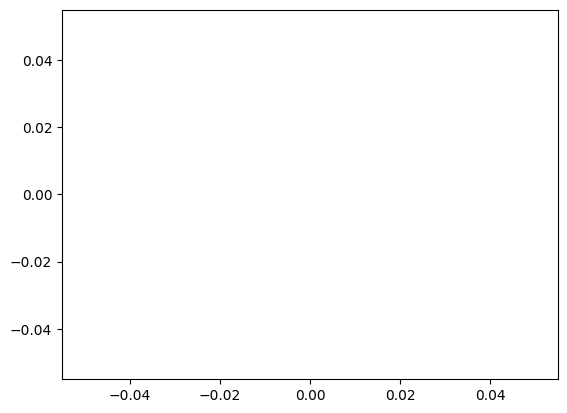

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


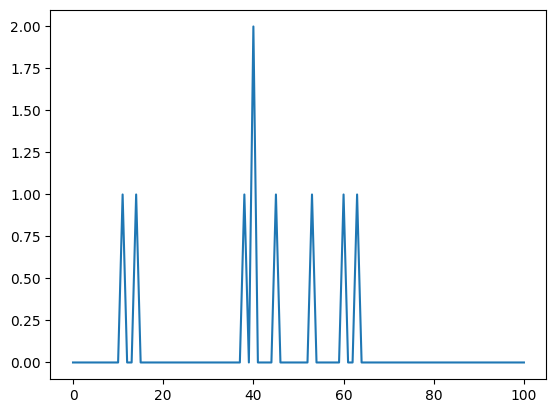

101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


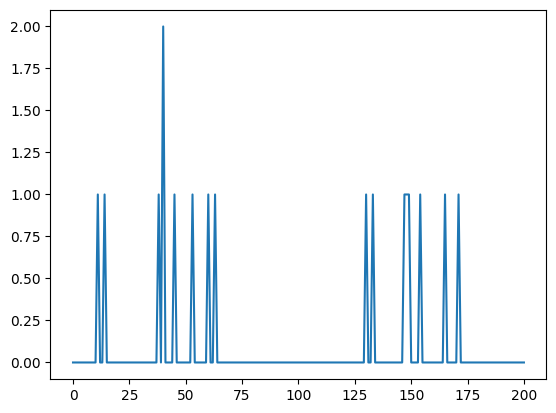

201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300


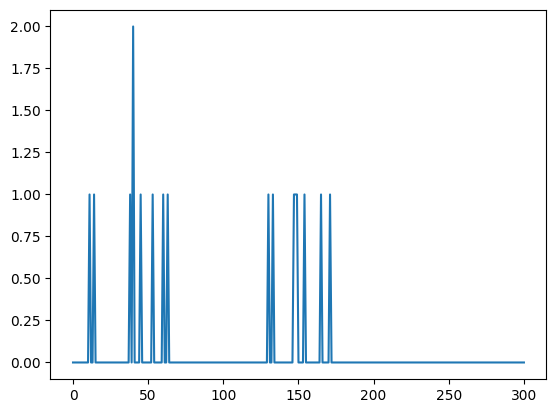

301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400


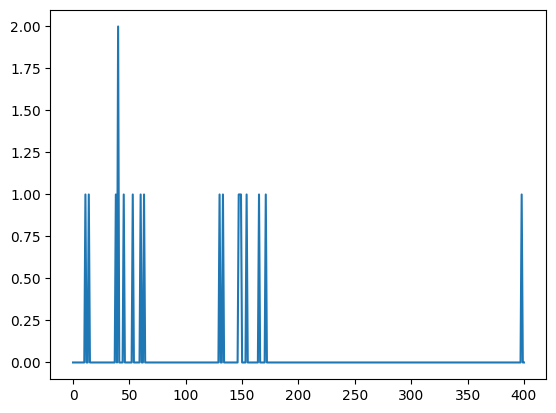

401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500


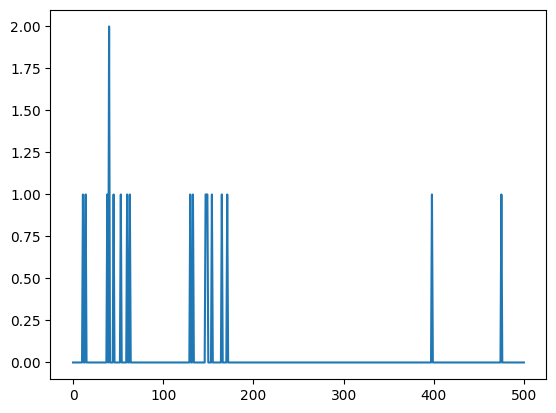

501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600


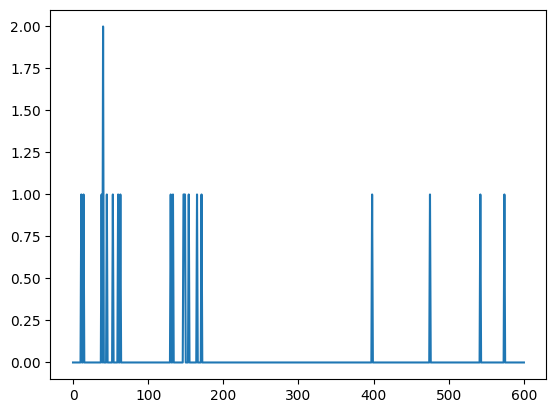

601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700


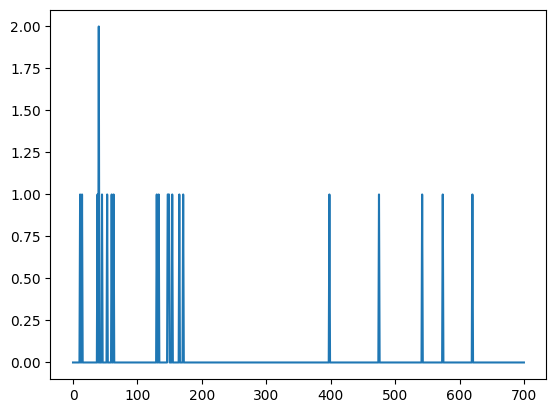

701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800


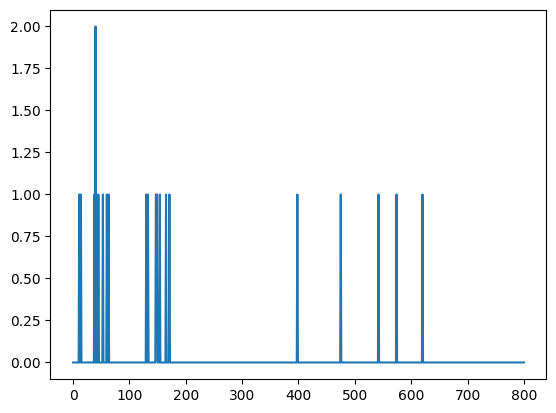

801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900


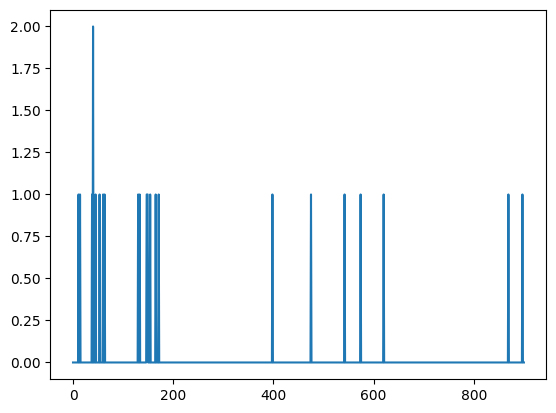

901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999
1000


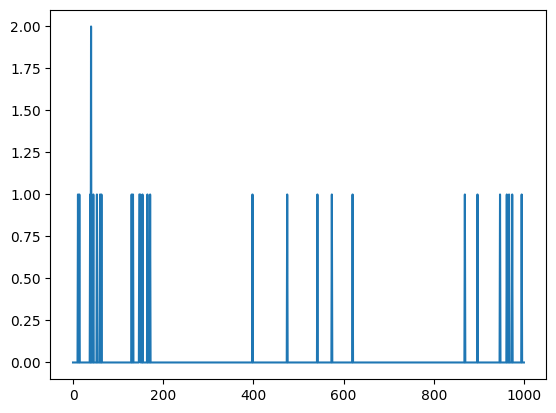

1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
1074
1075
1076
1077
1078
1079
1080
1081
1082
1083
1084
1085
1086
1087
1088
1089
1090
1091
1092
1093
1094
1095
1096
1097
1098
1099
1100


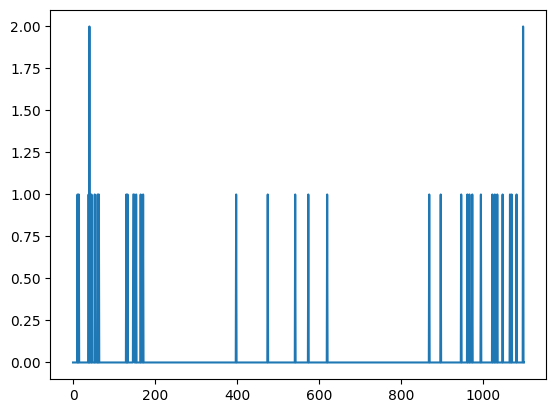

1101
1102
1103
1104
1105
1106
1107
1108
1109
1110
1111
1112
1113
1114
1115
1116
1117
1118
1119
1120
1121
1122
1123
1124
1125
1126
1127
1128
1129
1130
1131
1132
1133
1134
1135
1136
1137
1138
1139
1140
1141
1142
1143
1144
1145
1146
1147
1148
1149
1150
1151
1152
1153
1154
1155
1156
1157
1158
1159
1160
1161
1162
1163
1164
1165
1166
1167
1168
1169
1170
1171
1172
1173
1174
1175
1176
1177
1178
1179
1180
1181
1182
1183
1184
1185
1186
1187
1188
1189
1190
1191
1192
1193
1194
1195
1196
1197
1198
1199
1200


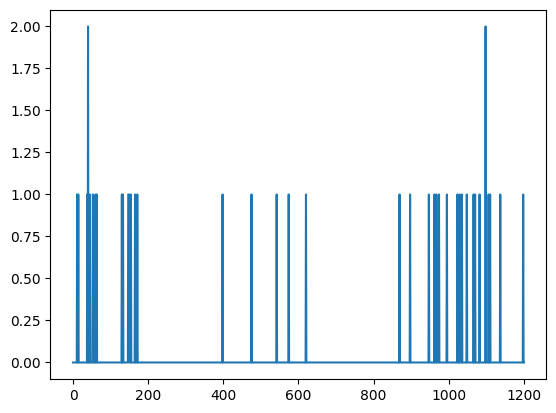

1201
1202
1203
1204
1205
1206
1207
1208
1209
1210
1211
1212
1213
1214
1215
1216
1217
1218
1219
1220
1221
1222
1223
1224
1225
1226
1227
1228
1229
1230
1231
1232
1233
1234
1235
1236
1237
1238
1239
1240
1241
1242
1243
1244
1245
1246
1247
1248
1249
1250
1251
1252
1253
1254
1255
1256
1257
1258
1259
1260
1261
1262
1263
1264
1265
1266
1267
1268
1269
1270
1271
1272
1273
1274
1275
1276
1277
1278
1279
1280
1281
1282
1283
1284
1285
1286
1287
1288
1289
1290
1291
1292
1293
1294
1295
1296
1297
1298
1299
1300


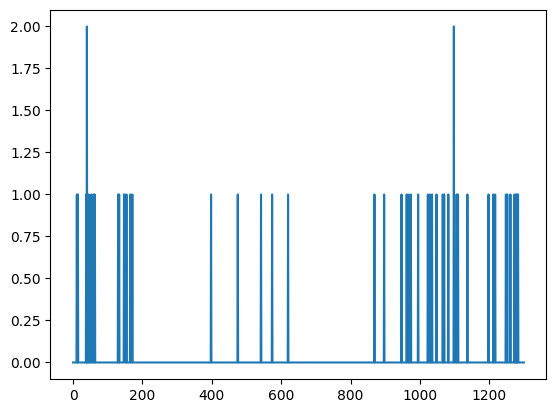

1301
1302
1303
1304
1305
1306
1307
1308
1309
1310
1311
1312
1313
1314
1315
1316
1317
1318
1319
1320
1321
1322
1323
1324
1325
1326
1327
1328
1329
1330
1331
1332
1333
1334
1335
1336
1337
1338
1339
1340
1341
1342
1343
1344
1345
1346
1347
1348
1349
1350
1351
1352
1353
1354
1355
1356
1357
1358
1359
1360
1361
1362
1363
1364
1365
1366
1367
1368
1369
1370
1371
1372
1373
1374
1375
1376
1377
1378
1379
1380
1381
1382
1383
1384
1385
1386
1387
1388
1389
1390
1391
1392
1393
1394
1395
1396
1397
1398
1399
1400


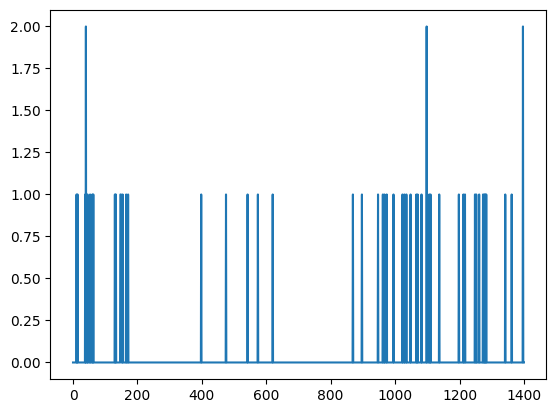

1401
1402
1403
1404
1405
1406
1407
1408
1409
1410
1411
1412
1413
1414
1415
1416
1417
1418
1419
1420
1421
1422
1423
1424
1425
1426
1427
1428
1429
1430
1431
1432
1433
1434
1435
1436
1437
1438
1439
1440
1441
1442
1443
1444
1445
1446
1447
1448
1449
1450
1451
1452
1453
1454
1455
1456
1457
1458
1459
1460
1461
1462
1463
1464
1465
1466
1467
1468
1469
1470
1471
1472
1473
1474
1475
1476
1477
1478
1479
1480
1481
1482
1483
1484
1485
1486
1487
1488
1489
1490
1491
1492
1493
1494
1495
1496
1497
1498
1499
1500


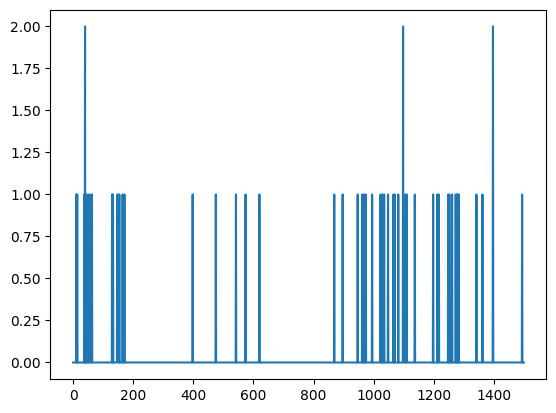

1501
1502
1503
1504
1505
1506
1507
1508
1509
1510
1511
1512
1513
1514
1515
1516
1517
1518
1519
1520
1521
1522
1523
1524
1525
1526
1527
1528
1529
1530
1531
1532
1533
1534
1535
1536
1537
1538
1539
1540
1541
1542
1543
1544
1545
1546
1547
1548
1549
1550
1551
1552
1553
1554
1555
1556
1557
1558
1559
1560
1561
1562
1563
1564
1565
1566
1567
1568
1569
1570
1571
1572
1573
1574
1575
1576
1577
1578
1579
1580
1581
1582
1583
1584
1585
1586
1587
1588
1589
1590
1591
1592
1593
1594
1595
1596
1597
1598
1599
1600


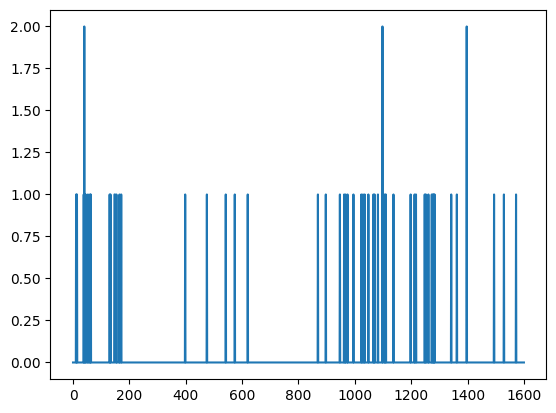

1601
1602
1603
1604
1605
1606
1607
1608
1609
1610
1611
1612
1613
1614
1615
1616
1617
1618
1619
1620
1621
1622
1623
1624
1625
1626
1627
1628
1629
1630
1631
1632
1633
1634
1635
1636
1637
1638
1639
1640
1641
1642
1643
1644
1645
1646
1647
1648
1649
1650
1651
1652
1653
1654
1655
1656
1657
1658
1659
1660
1661
1662
1663
1664
1665
1666
1667
1668
1669
1670
1671
1672
1673
1674
1675
1676
1677
1678
1679
1680
1681
1682
1683
1684
1685
1686
1687
1688
1689
1690
1691
1692
1693
1694
1695
1696
1697
1698
1699
1700


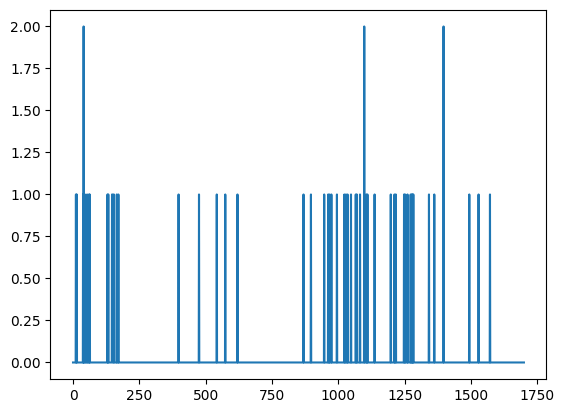

1701
1702
1703
1704
1705
1706
1707
1708
1709
1710
1711
1712
1713
1714
1715
1716
1717
1718
1719
1720
1721
1722
1723
1724
1725
1726
1727
1728
1729
1730
1731
1732
1733
1734
1735
1736
1737
1738
1739
1740
1741
1742
1743
1744
1745
1746
1747
1748
1749
1750
1751
1752
1753
1754
1755
1756
1757
1758
1759
1760
1761
1762
1763
1764
1765
1766
1767
1768
1769
1770
1771
1772
1773
1774
1775
1776
1777
1778
1779
1780
1781
1782
1783
1784
1785
1786
1787
1788
1789
1790
1791
1792
1793
1794
1795
1796
1797
1798
1799
1800


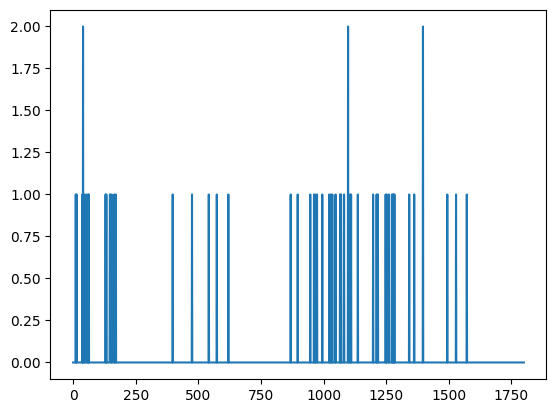

1801
1802
1803
1804
1805
1806
1807
1808
1809
1810
1811
1812
1813
1814
1815
1816
1817
1818
1819
1820
1821
1822
1823
1824
1825
1826
1827
1828
1829
1830
1831
1832
1833
1834
1835
1836
1837
1838
1839
1840
1841
1842
1843
1844
1845
1846
1847
1848
1849
1850
1851
1852
1853
1854
1855
1856
1857
1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900


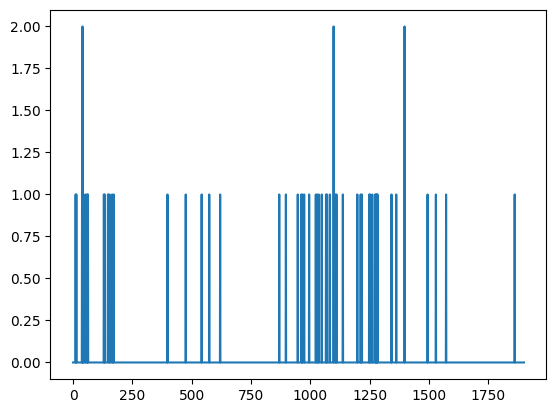

1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000


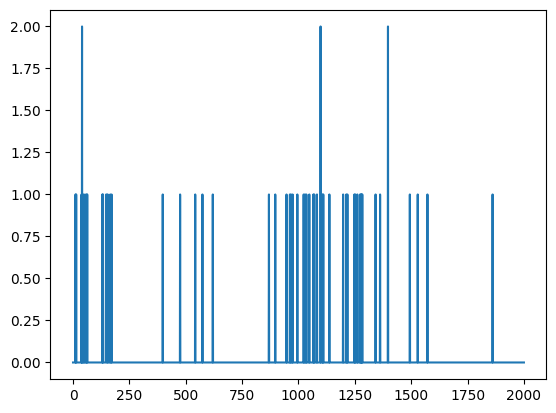

2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100


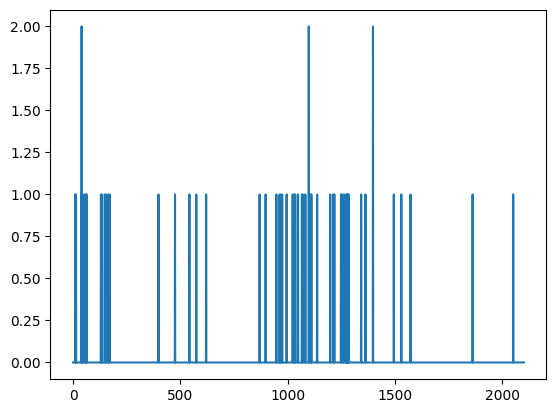

2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126
2127
2128
2129
2130
2131
2132
2133
2134
2135
2136
2137
2138
2139
2140
2141
2142
2143
2144
2145
2146
2147
2148
2149
2150
2151
2152
2153
2154
2155
2156
2157
2158
2159
2160
2161
2162
2163
2164
2165
2166
2167
2168
2169
2170
2171
2172
2173
2174
2175
2176
2177
2178
2179
2180
2181
2182
2183
2184
2185
2186
2187
2188
2189
2190
2191
2192
2193
2194
2195
2196
2197
2198
2199
2200


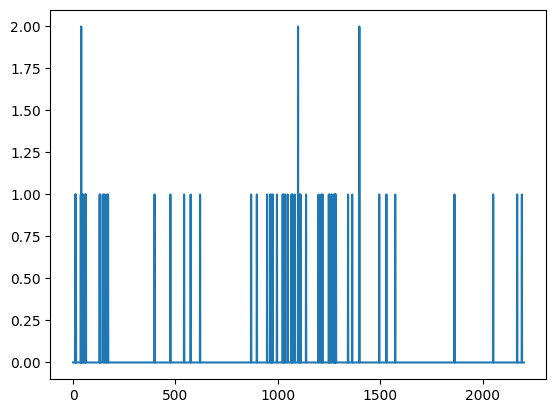

2201
2202
2203
2204
2205
2206
2207
2208
2209
2210
2211
2212
2213
2214
2215
2216
2217
2218
2219
2220
2221
2222
2223
2224
2225
2226
2227
2228
2229
2230
2231
2232
2233
2234
2235
2236
2237
2238
2239
2240
2241
2242
2243
2244
2245
2246
2247
2248
2249
2250
2251
2252
2253
2254
2255
2256
2257
2258
2259
2260
2261
2262
2263
2264
2265
2266
2267
2268
2269
2270
2271
2272
2273
2274
2275
2276
2277
2278
2279
2280
2281
2282
2283
2284
2285
2286
2287
2288
2289
2290
2291
2292
2293
2294
2295
2296
2297
2298
2299
2300


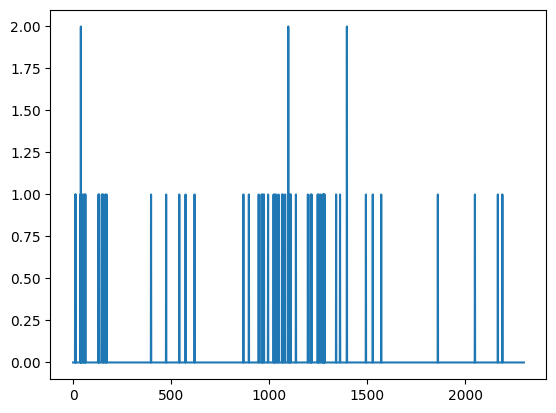

2301
2302
2303
2304
2305
2306
2307
2308
2309
2310
2311
2312
2313
2314
2315
2316
2317
2318
2319
2320
2321
2322
2323
2324
2325
2326
2327
2328
2329
2330
2331
2332
2333
2334
2335
2336
2337
2338
2339
2340
2341
2342
2343
2344
2345
2346
2347
2348
2349
2350
2351
2352
2353
2354
2355
2356
2357
2358
2359
2360
2361
2362
2363
2364
2365
2366
2367
2368
2369
2370
2371
2372
2373
2374
2375
2376
2377
2378
2379
2380
2381
2382
2383
2384
2385
2386
2387
2388
2389
2390
2391
2392
2393
2394
2395
2396
2397
2398
2399
2400


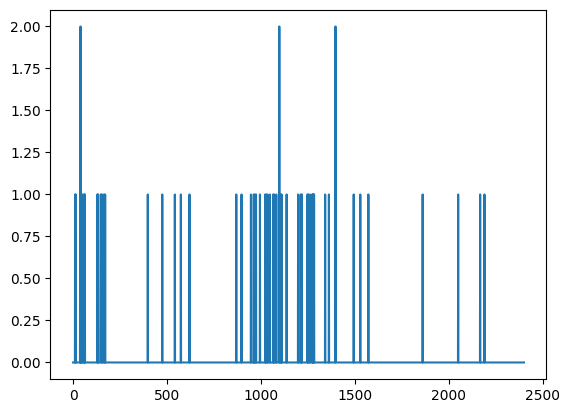

2401
2402
2403
2404
2405
2406
2407
2408
2409
2410
2411
2412
2413
2414
2415
2416
2417
2418
2419
2420
2421
2422
2423
2424
2425
2426
2427
2428
2429
2430
2431
2432
2433
2434
2435
2436
2437
2438
2439
2440
2441
2442
2443
2444
2445
2446
2447
2448
2449
2450
2451
2452
2453
2454
2455
2456
2457
2458
2459
2460
2461
2462
2463
2464
2465
2466
2467
2468
2469
2470
2471
2472
2473
2474
2475
2476
2477
2478
2479
2480
2481
2482
2483
2484
2485
2486
2487
2488
2489
2490
2491
2492
2493
2494
2495
2496
2497
2498
2499
2500


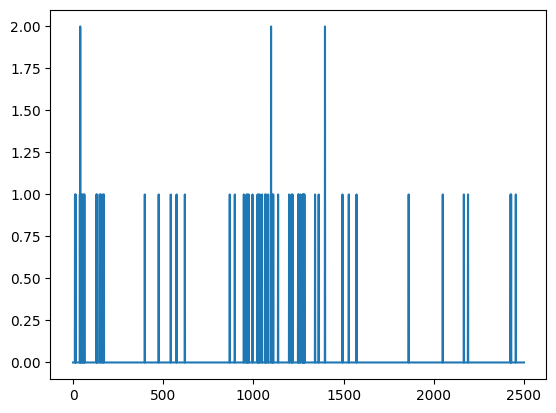

2501
2502
2503
2504
2505
2506
2507
2508
2509
2510
2511
2512
2513
2514
2515
2516
2517
2518
2519
2520
2521
2522
2523
2524
2525
2526
2527
2528
2529
2530
2531
2532
2533
2534
2535
2536
2537
2538
2539
2540
2541
2542
2543
2544
2545
2546
2547
2548
2549
2550
2551
2552
2553
2554
2555
2556
2557
2558
2559
2560
2561
2562
2563
2564
2565
2566
2567
2568
2569
2570
2571
2572
2573
2574
2575
2576
2577
2578
2579
2580
2581
2582
2583
2584
2585
2586
2587
2588
2589
2590
2591
2592
2593
2594
2595
2596
2597
2598
2599
2600


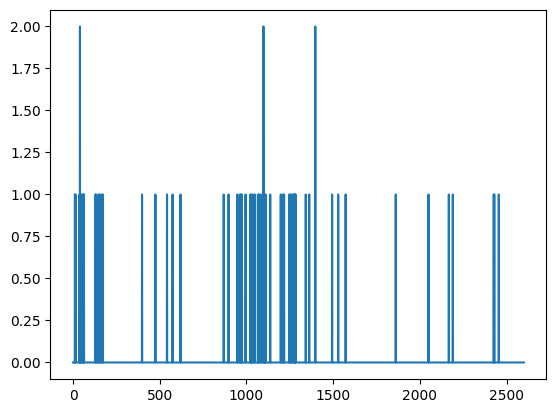

2601
2602
2603
2604
2605
2606
2607
2608
2609
2610
2611
2612
2613
2614
2615
2616
2617
2618
2619
2620
2621
2622
2623
2624
2625
2626
2627
2628
2629
2630
2631
2632
2633
2634
2635
2636
2637
2638
2639
2640
2641
2642
2643
2644
2645
2646
2647
2648
2649
2650
2651
2652
2653
2654
2655
2656
2657
2658
2659
2660
2661
2662
2663
2664
2665
2666
2667
2668
2669
2670
2671
2672
2673
2674
2675
2676
2677
2678
2679
2680
2681
2682
2683
2684
2685
2686
2687
2688
2689
2690
2691
2692
2693
2694
2695
2696
2697
2698
2699
2700


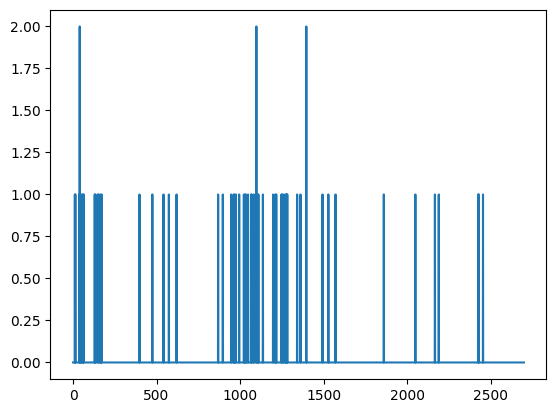

2701
2702
2703
2704
2705
2706
2707
2708
2709
2710
2711
2712
2713
2714
2715
2716
2717
2718
2719
2720
2721
2722
2723
2724
2725
2726
2727
2728
2729
2730
2731
2732
2733
2734
2735
2736
2737
2738
2739
2740
2741
2742
2743
2744
2745
2746
2747
2748
2749
2750
2751
2752
2753
2754
2755
2756
2757
2758
2759
2760
2761
2762
2763
2764
2765
2766
2767
2768
2769
2770
2771
2772
2773
2774
2775
2776
2777
2778
2779
2780
2781
2782
2783
2784
2785
2786
2787
2788
2789
2790
2791
2792
2793
2794
2795
2796
2797
2798
2799
2800


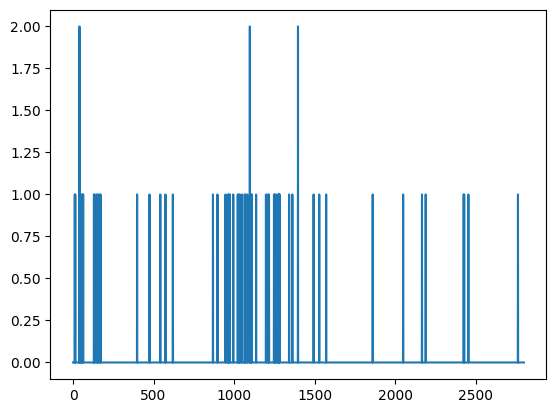

2801
2802
2803
2804
2805
2806
2807
2808
2809
2810
2811
2812
2813
2814
2815
2816
2817
2818
2819
2820
2821
2822
2823
2824
2825
2826
2827
2828
2829
2830
2831
2832
2833
2834
2835
2836
2837
2838
2839
2840
2841
2842
2843
2844
2845
2846
2847
2848
2849
2850
2851
2852
2853
2854
2855
2856
2857
2858
2859
2860
2861
2862
2863
2864
2865
2866
2867
2868
2869
2870
2871
2872
2873
2874
2875
2876
2877
2878
2879
2880
2881
2882
2883
2884
2885
2886
2887
2888
2889
2890
2891
2892
2893
2894
2895
2896
2897
2898
2899
2900


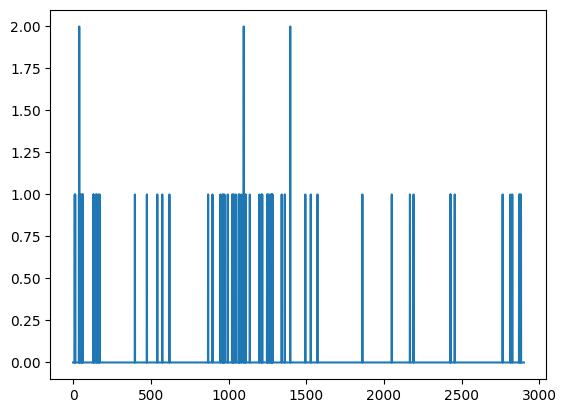

2901
2902
2903
2904
2905
2906
2907
2908
2909
2910
2911
2912
2913
2914
2915
2916
2917
2918
2919
2920
2921
2922
2923
2924
2925
2926
2927
2928
2929
2930
2931
2932
2933
2934
2935
2936
2937
2938
2939
2940
2941
2942
2943
2944
2945
2946
2947
2948
2949
2950
2951
2952
2953
2954
2955
2956
2957
2958
2959
2960
2961
2962
2963
2964
2965
2966
2967
2968
2969
2970
2971
2972
2973
2974
2975
2976
2977
2978
2979
2980
2981
2982
2983
2984
2985
2986
2987
2988
2989
2990
2991
2992
2993
2994
2995
2996
2997
2998
2999
3000


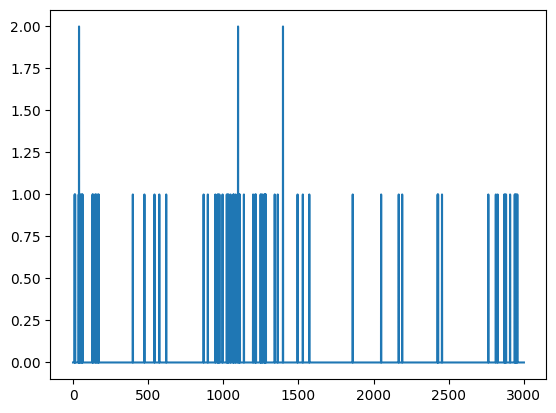

3001
3002
3003
3004
3005
3006
3007
3008
3009
3010
3011
3012
3013
3014
3015
3016
3017
3018
3019
3020
3021
3022
3023
3024
3025
3026
3027
3028
3029
3030
3031
3032
3033
3034
3035
3036
3037
3038
3039
3040
3041
3042
3043
3044
3045
3046
3047
3048
3049
3050
3051
3052
3053
3054
3055
3056
3057
3058
3059
3060
3061
3062
3063
3064
3065
3066
3067
3068
3069
3070
3071
3072
3073
3074
3075
3076
3077
3078
3079
3080
3081
3082
3083
3084
3085
3086
3087
3088
3089
3090
3091
3092
3093
3094
3095
3096
3097
3098
3099
3100


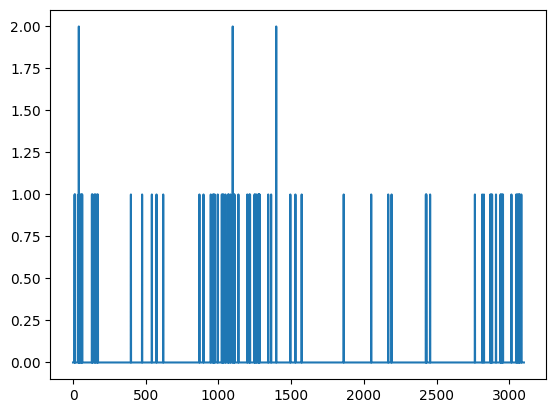

3101
3102
3103
3104
3105
3106
3107
3108
3109
3110
3111
3112
3113
3114
3115
3116
3117
3118
3119
3120
3121
3122
3123
3124
3125
3126
3127
3128
3129
3130
3131
3132
3133
3134
3135
3136
3137
3138
3139
3140
3141
3142
3143
3144
3145
3146
3147
3148
3149
3150
3151
3152
3153
3154
3155
3156
3157
3158
3159
3160
3161
3162
3163
3164
3165
3166
3167
3168
3169
3170
3171
3172
3173
3174
3175
3176
3177
3178
3179
3180
3181
3182
3183
3184
3185
3186
3187
3188
3189
3190
3191
3192
3193
3194
3195
3196
3197
3198
3199
3200


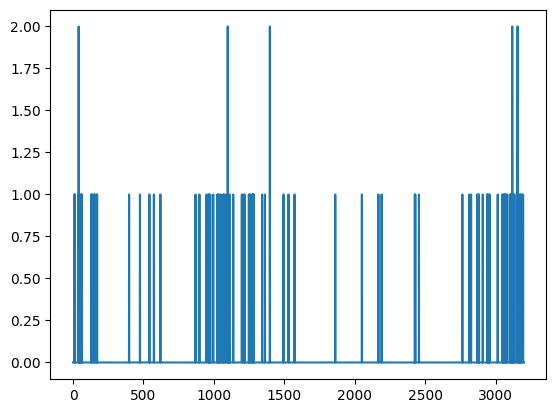

3201
3202
3203
3204
3205
3206
3207
3208
3209
3210
3211
3212
3213
3214
3215
3216
3217
3218
3219
3220
3221
3222
3223
3224
3225
3226
3227
3228
3229
3230
3231
3232
3233
3234
3235
3236
3237
3238
3239
3240
3241
3242
3243
3244
3245
3246
3247
3248
3249
3250
3251
3252
3253
3254
3255
3256
3257
3258
3259
3260
3261
3262
3263
3264
3265
3266
3267
3268
3269
3270
3271
3272
3273
3274
3275
3276
3277
3278
3279
3280
3281
3282
3283
3284
3285
3286
3287
3288
3289
3290
3291
3292
3293
3294
3295
3296
3297
3298
3299
3300


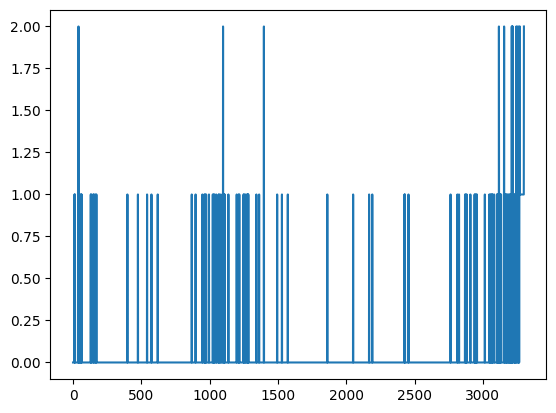

3301
3302
3303
3304
3305
3306
3307
3308
3309
3310
3311
3312
3313
3314
3315
3316
3317
3318
3319
3320
3321
3322
3323
3324
3325
3326
3327
3328
3329
3330
3331
3332
3333
3334
3335
3336
3337
3338
3339
3340
3341
3342
3343
3344
3345
3346
3347
3348
3349
3350
3351
3352
3353
3354
3355
3356
3357
3358
3359
3360
3361
3362
3363
3364
3365
3366
3367
3368
3369
3370
3371
3372
3373
3374
3375
3376
3377
3378
3379
3380
3381
3382
3383
3384
3385
3386
3387
3388
3389
3390
3391
3392
3393
3394
3395
3396
3397
3398
3399
3400


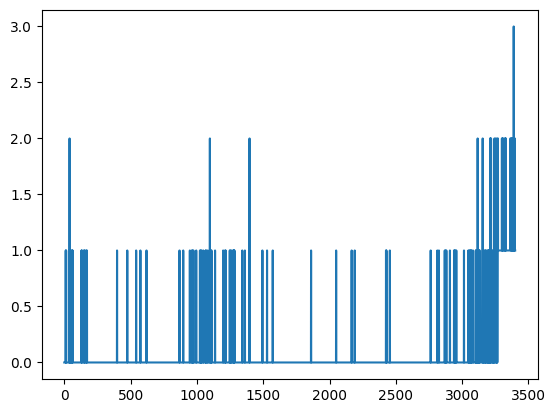

3401
3402
3403
3404
3405
3406
3407
3408
3409
3410
3411
3412
3413
3414
3415
3416
3417
3418
3419
3420
3421
3422
3423
3424
3425
3426
3427
3428
3429
3430
3431
3432
3433
3434
3435
3436
3437
3438
3439
3440
3441
3442
3443
3444
3445
3446
3447
3448
3449
3450
3451
3452
3453
3454
3455
3456
3457
3458
3459
3460
3461
3462
3463
3464
3465
3466
3467
3468
3469
3470
3471
3472
3473
3474
3475
3476
3477
3478
3479
3480
3481
3482
3483
3484
3485
3486
3487
3488
3489
3490
3491
3492
3493
3494
3495
3496
3497
3498
3499
3500


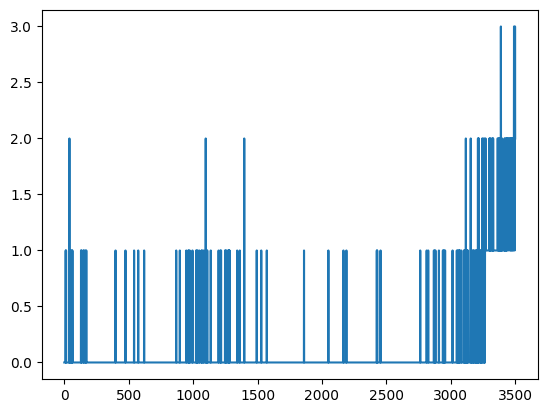

3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600


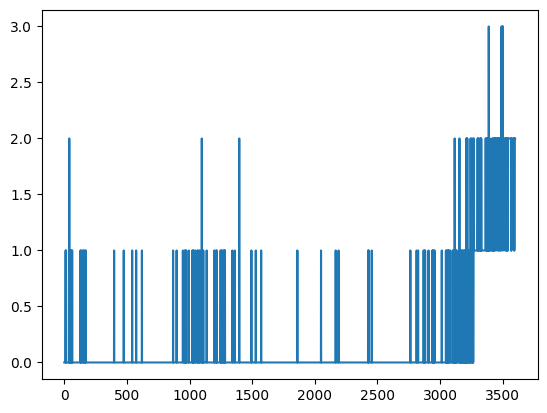

3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700


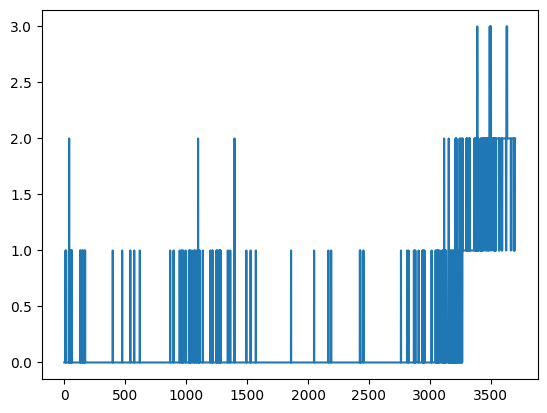

3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750
3751
3752
3753
3754
3755
3756
3757
3758
3759
3760
3761
3762
3763
3764
3765
3766
3767
3768
3769
3770
3771
3772
3773
3774
3775
3776
3777
3778
3779
3780
3781
3782
3783
3784
3785
3786
3787
3788
3789
3790
3791
3792
3793
3794
3795
3796
3797
3798
3799
3800


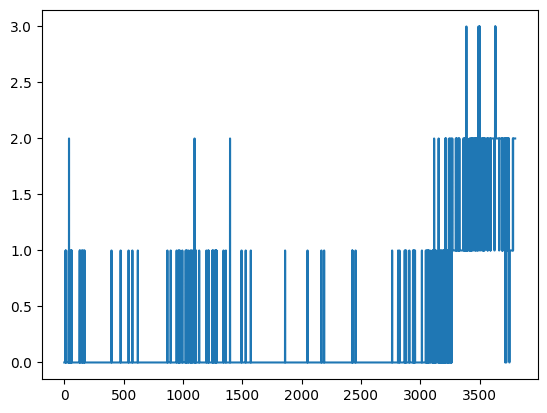

3801
3802
3803
3804
3805
3806
3807
3808
3809
3810
3811
3812
3813
3814
3815
3816
3817
3818
3819
3820
3821
3822
3823
3824
3825
3826
3827
3828
3829
3830
3831
3832
3833
3834
3835
3836
3837
3838
3839
3840
3841
3842
3843
3844
3845
3846
3847
3848
3849
3850
3851
3852
3853
3854
3855
3856
3857
3858
3859
3860
3861
3862
3863
3864
3865
3866
3867
3868
3869
3870
3871
3872
3873
3874
3875
3876
3877
3878
3879
3880
3881
3882
3883
3884
3885
3886
3887
3888
3889
3890
3891
3892
3893
3894
3895
3896
3897
3898
3899
3900


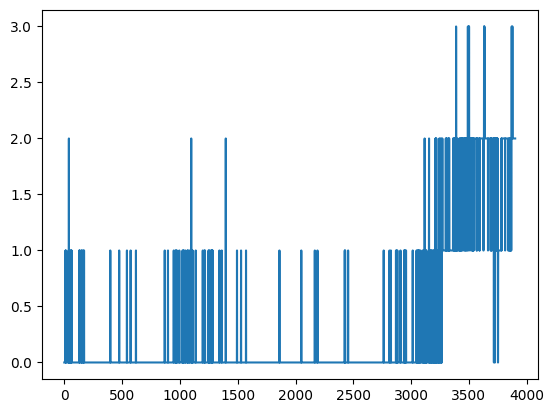

3901
3902
3903
3904
3905
3906
3907
3908
3909
3910
3911
3912
3913
3914
3915
3916
3917
3918
3919
3920
3921
3922
3923
3924
3925
3926
3927
3928
3929
3930
3931
3932
3933
3934
3935
3936
3937
3938
3939
3940
3941
3942
3943
3944
3945
3946
3947
3948
3949
3950
3951
3952
3953
3954
3955
3956
3957
3958
3959
3960
3961
3962
3963
3964
3965
3966
3967
3968
3969
3970
3971
3972
3973
3974
3975
3976
3977
3978
3979
3980
3981
3982
3983
3984
3985
3986
3987
3988
3989
3990
3991
3992
3993
3994
3995
3996
3997
3998
3999
4000


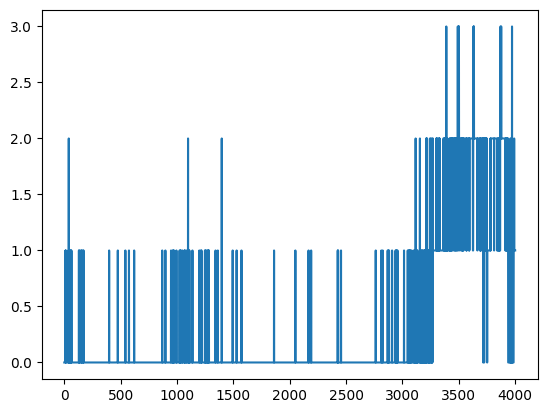

4001
4002
4003
4004
4005
4006
4007
4008
4009
4010
4011
4012
4013
4014
4015
4016
4017
4018
4019
4020
4021
4022
4023
4024
4025
4026
4027
4028
4029
4030
4031
4032
4033
4034
4035
4036
4037
4038
4039
4040
4041
4042
4043
4044
4045
4046
4047
4048


KeyboardInterrupt: 

In [16]:
import matplotlib.pyplot as plt

pg.init()
screen=pg.display.set_mode((1200,576))
pg.display.set_caption("Hello_fine")
clock=pg.time.Clock()
font = pg.font.Font('freesansbold.ttf', 22)
sky=pg.image.load('game_dev/finalbg.jpg').convert()
pipe=pg.image.load('game_dev/pipe.png').convert_alpha()
pipe=pg.transform.scale(pipe,(100,500))
pipet=pg.transform.rotate(pipe,180)
pipet=pg.transform.flip(pipet,True,False)
pipet_rect=pipet.get_rect(topleft=(1200,-50))
pipe_rect=pipe.get_rect(topleft=(1200,300))
pipe_rect_copy=pipe.get_rect(topleft=(550,300))
pipet_rect_copy=pipet.get_rect(topleft=(550,-50))
bird=pg.image.load('game_dev/bird.png').convert_alpha()
bird=pg.transform.scale(bird,(70,50))
bird_rect=bird.get_rect(center=(100,100))
sbt=font.render("START",True,"red")
sbt_rect=sbt.get_rect(center=(600,288))
screen.blit(sbt,sbt_rect)
l=[]
#defining timer for the obstacles to occur
for i in range(10000):
    bird_rect=bird.get_rect(center=(100,400))
    timer=pg.USEREVENT+1
    pg.time.set_timer(timer,1000)

    #bird=pg.transform.rotate(bird,-30)
    obs_list=[[500,400],[900,300],[1200,400]]
    obst_list=[[500,400-680],[900,300-680],[1200,400-680]]
    t=0
    a=0
    score="0"
    s=bird_rect.centery
    text = font.render(score, True, (77,208,225))
    text_rect = text.get_rect(center=(600,80))
    el=pg.draw.circle(screen,"blue",bird_rect.center,20)
    done=False
    cur_st=[0,0,0]
    cur_st[0]=(obs_list[0][0]-100)/4
    cur_st[1]=obs_list[0][1]-bird_rect.centery+301
    cur_st[2]=0
    smax=0
    while not done:
        #draw everything and update
        for event in pg.event.get():
            if event.type==pg.QUIT:
                print(l)
                pg.quit()
                sys.exit()
            #if event.type==pg.KEYDOWN:
                #s=s+t*t-t*a
                #a=21
                #t=0.5
            if event.type==timer:
                x=4*random.randint(300,330)
                y=400+random.randint(-150,100)
                obs_list.append([x,y])
                obst_list.append([x,y-680])
        # defining thr rectangle postions
        el=pg.draw.circle(screen,"blue",bird_rect.center,20)
        
        #S
        
        screen.blit(sky,(-100,0))
        bird_rect.centery=s+t*t-t*a
        v=a-t*2
        screen.blit(bird,bird_rect)
        screen.blit(text,text_rect)

        obs_list,obst_list=obstacle_render(obs_list,obst_list)
        cur_st_en=create_tile_encoding(cur_st)
        #A
        if random.uniform(0,1)<eps:
            action=random.randint(0,1)
        else:
            action=np.argmax(Q_value[tuple(cur_st_en)])
        cur_st.append(action)
        cur_st_en.append(action)
        
        #S'
        next_state=get_next_state(cur_st,obs_list)
        next_state_en=create_tile_encoding(next_state)
        # in one time stamp x reduces by one and y by an amout specified by an equation of motion
        # so in order to find the subsequent states i would need to do a lookahead in the s using a hypothetical 
        # jump or no jump and then check the max of q values of both states and decide greedly....

        
        
        if cur_st[3]==0:
            ys=s+(t+0.5)*(t+0.5)-(t+0.5)*a
        else:
            ys=s+t*t-t*a + 0.5*0.5 -0.5*21
        el1=pg.draw.circle(screen,"blue",(104,ys),20)
        if  el1.colliderect(pipe.get_rect(topright=obs_list[0])) or el1.colliderect(pipet.get_rect(topright=obst_list[0])) or el1.bottom>=561 or el1.top<=5:
            reward=-300
            done=True
            Q_value[tuple(cur_st_en)]+=td_error*(reward-Y*Q_value[tuple(cur_st_en)])
        else:
            if random.uniform(0,1)<eps:
                action_next=random.randint(0,1)
            else:
                action_next=np.argmax(Q_value[tuple(next_state_en)])
            next_state.append(action_next)
            next_state_en.append(action_next)
            reward=0.5
            if next_state[0]==0:
                reward=10
            Q_value[tuple(cur_st_en)]+=td_error*(reward + Y*(Q_value[tuple(next_state_en)]-Q_value[tuple(cur_st_en)]))

        if action==1:
            s=s+t*t-t*a
            t=0
            a=21

        if obs_list and el.right==obs_list[0][0]+16:
            score=str(eval(score)+1)
            smax=max(0,eval(score))
            text = font.render(score, True,(77,208,225))
        #if (obs_list and obst_list and (el.colliderect(pipe.get_rect(topleft=obs_list[0])) or el.colliderect(pipet.get_rect(topleft=obst_list[0])))) or bird_rect.bottom>=576 or bird_rect.top<=0:
            #pg.quit()
            #sys.exit()

        t=t+0.5
        cur_st=[next_state[0],next_state[1],next_state[2]]
        pg.display.update()
        clock.tick(120)
    l.append(smax)
    print(i)
    if i%100==0:
        plt.plot(np.arange(i+1),l)
        plt.show()
    